# Deep Hedging LSTM and Utility Indifference pricing

Import first all relevant libraries (and set plotting style):

In [ ]:
import numpy as np
import math
import numpy.random as npr
from scipy.stats import norm
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as kb
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Pre-requisite: Formulas 

Functions that compute <i>option</i> prices and delta under the Black-Scholes model:

In [ ]:
def BlackScholesCall(S0,r,sigma,T,K):
    d1 =  1 / (sigma * np.sqrt(T)) * (np.log(S0/K) + (r+sigma**2/2)*T)
    d2 = d1 - sigma * np.sqrt(T)
    return norm.cdf(d1) * S0 - norm.cdf(d2) * K * np.exp(-r*T)
def BlackScholesCallDelta(S0,r,sigma,T,K):
    d1 =  1 / (sigma * np.sqrt(T)) * (np.log(S0/K) + (r+sigma**2/2)*T)
    return norm.cdf(d1)

def generate_heston_paths(S, T, r, kappa, theta, v_0, rho, xi, 
                          steps, Npaths, return_vol=False):
    np.random.seed(12345)
    dt = T/steps
    size = (Npaths, steps)
    prices = np.zeros(size)
    sigs = np.zeros(size)
    S_t = S
    v_t = v_0
    for t in range(steps):
        WT = np.random.multivariate_normal(np.array([0,0]), 
                                           cov = np.array([[1,rho],
                                                          [rho,1]]), 
                                           size=Npaths) * np.sqrt(dt) 
        
        S_t = S_t*(np.exp( (r- 0.5*v_t)*dt+ np.sqrt(v_t) *WT[:,0] ) ) 
        v_t = np.abs(v_t + kappa*(theta-v_t)*dt + xi*np.sqrt(v_t)*WT[:,1])
        prices[:, t] = S_t
        sigs[:, t] = v_t
        prices_transpose = np.transpose(prices)
        sigs_transpose = np.transpose(sigs)
        
    if return_vol:
        return prices, sigs

    return prices

def call_price(stock_path, steps, N):
  #prices = np.transpose(generate_heston_paths(S, T, r, kappa, theta, v_0, rho, xi, 
                        #steps, N, return_vol=False))
  
  call_array = stock_path[-1] - K
  call_price = np.mean(call_array)
  return call_price

def loss_util(lamb,k,option_type):
    def loss(y_true,y_pred):
        gain = kb.sum(y_pred * y_true,axis=-1)
        ST = S_0 + kb.sum(y_true, axis=-1)
        var = kb.abs(y_pred[:,1:T]-y_pred[:,0:T-1])   
        tc = (kb.cumsum(y_true, axis=1)+S_0)*k
        tc_0 = k * S_0
        cost = kb.abs(y_pred[:,0])*tc_0+kb.abs(y_pred[:,T-1])*tc[:,T-1] + kb.sum(tc[:,0:T-1]*var, axis=1)
        
        c = S_0*C
        indicator_AC = tf.math.maximum(tf.math.sign(y_pred[:,int(T/2):int(T/2) +1] - B_AC),0.) # 1 if Autocalls at 6M, 0 otherwise
        pmax = tf.math.reduce_max(kb.cumsum(y_true, axis=1)+S_0,axis=-1) #running maximum
        pmin = tf.math.reduce_min(kb.cumsum(y_true, axis=1)+S_0,axis=-1) #running minimum
        indicator_AC_cont = tf.math.maximum(tf.math.sign(pmax - B_AC),0.) #1 if running max>B_AC, 0 otherwise
        indicator_DIP = tf.math.maximum(tf.math.sign(B_DIP-pmin),0.) # 1 if running_minimum<B_DIP, 0 otherwise
        indicator = tf.math.maximum(tf.math.sign(B_AC-pmax),0.)
        option_list = {
        'call' : kb.maximum(S_0 + kb.sum(y_true,axis=-1) - K,0.),
        'put' : kb.maximum(-S_0 - kb.sum(y_true,axis=-1) + K,0.),
        'cuo' : kb.maximum(S_0 + kb.sum(y_true,axis=-1) - K,0.)*indicator,
        'autocall' : (S_0 + c)*(indicator_AC) \
                   +(S_0 + c)*(1-indicator_AC) -kb.maximum(K - S_0 - kb.sum(y_true,axis=-1),0.)\
                   *(indicator_DIP)*(1-indicator_AC), #Pays back performance at maturity if doesn't autocalls at 6M
        'autocall_continuous' : (S_0 + c)*(indicator_AC_cont) \
                   +(S_0 + c)*(1-indicator_AC_cont) -kb.maximum(K - S_0 - kb.sum(y_true,axis=-1),0.)\
                   *(indicator_DIP)*(1-indicator_AC_cont), #Autocall obs date is continuous
        }
        
        liability = option_list[option_type]
        pnl = gain - liability - cost
        return tf.math.expm1(-lamb*pnl)/lamb
    return loss


# Deep Hedging: Parameters

In [ ]:
batch_size = 5000
option_type = "autocall_continuous"
output_activation_layer = "softplus" # "sigmoid", "tanh", "softplus"
B_DIP, B_AC,C = 0.7, 1.3, 0.03

K=1
risk_aversion = (1,5,10,15)
cost_level = (0,0.0005,0.005,0.05)

units = 20
epochs_fast = 10
epochs_slow = 10
epochs_slow_iter = 9
opt_fast = keras.optimizers.Adam(learning_rate=0.01)
opt_slow = keras.optimizers.Adam(learning_rate=0.001)

# Black Scholes

## Simulating Stock Path

We set the parameter values as before:

In [ ]:
sigma = 0.5
mu = -0.5*sigma**2 # Such that mu is a martingale, we'll let r=0 but can be relaxed
T = 100
S_0 = 1
r=0

And we generate the training samples:

In [ ]:
npr.seed(12345)
N = 100000
xi = npr.normal(0, np.sqrt(1 / T), (N, T))
W = np.apply_along_axis(np.cumsum, 1, xi)
W = np.concatenate((np.zeros((N, 1)), W),1)
drift = np.linspace(0, mu , T + 1)
drift = np.reshape(drift, (1, T + 1))
drift = np.repeat(drift, N, axis=0)
Ti = np.tile(np.linspace(0, 1, T+1)[0:T], (N, 1))
S_BS = S_0 * np.exp(drift + sigma * W)
dS_BS = np.diff(S_BS, 1, 1)
X_BS = np.stack([Ti, S_BS[:,0:T]], axis=-1)
#tim = np.linspace(0,1,T+1)

## Training Network

Utility Indifference pricing with Exponential Utility:

\begin{align} \label{eq:exp_utility_function}
-U_\lambda(x):=\frac{1}{\lambda}\exp{(-\lambda x)},\qquad x \in \mathbb{R}
\end{align} 

We used a network $f$ such that
\begin{equation*}
f \in \mathcal{N}_4(2,100,100,100,1; \mathrm{ReLU},\mathrm{ReLU},\mathrm{ReLU},\mathrm{Softplus}).
\end{equation*}

In [ ]:
F1_BS, F5_BS, F10_BS, F15_BS = [], [], [], []
F_BS = [F1_BS, F5_BS, F10_BS, F15_BS]
LSTM1_BS, LSTM5_BS, LSTM10_BS, LSTM15_BS = [], [], [], []
LSTM_BS = [LSTM1_BS,LSTM5_BS,LSTM10_BS,LSTM15_BS]
for i in range(len(risk_aversion)): #range lambda
  for j in range(len(risk_aversion)): #range cost level
    prices = keras.layers.Input(shape=(T,2))
    LSTM_BS[i].append(keras.layers.LSTM(units, return_sequences=True))
    layer_dense = keras.layers.Dense(1, activation="softplus")
    y = LSTM_BS[i][j](prices)
    hedges = layer_dense(y)
    F_BS[i].append(keras.models.Model(inputs=prices, outputs=hedges))
    #F_BS.summary()

In [ ]:
i, j = 0, 0
F_BS[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BS[i][j].fit(X_BS, dS_BS, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_BS[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_BS[i][j].fit(X_BS,dS_BS,batch_size=batch_size,epochs=epochs_slow)

i, j = 0, 1
F_BS[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BS[i][j].fit(X_BS, dS_BS, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_BS[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_BS[i][j].fit(X_BS,dS_BS,batch_size=batch_size,epochs=epochs_slow)

i, j = 0, 2
F_BS[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BS[i][j].fit(X_BS, dS_BS, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_BS[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_BS[i][j].fit(X_BS,dS_BS,batch_size=batch_size,epochs=epochs_slow)

i, j = 0, 3
F_BS[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BS[i][j].fit(X_BS, dS_BS, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_BS[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_BS[i][j].fit(X_BS,dS_BS,batch_size=batch_size,epochs=epochs_slow)

i, j = 1, 0
F_BS[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BS[i][j].fit(X_BS, dS_BS, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_BS[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_BS[i][j].fit(X_BS,dS_BS,batch_size=batch_size,epochs=epochs_slow)

i, j = 1, 1
F_BS[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BS[i][j].fit(X_BS, dS_BS, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_BS[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_BS[i][j].fit(X_BS,dS_BS,batch_size=batch_size,epochs=epochs_slow)

i, j = 1, 2
F_BS[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BS[i][j].fit(X_BS, dS_BS, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_BS[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_BS[i][j].fit(X_BS,dS_BS,batch_size=batch_size,epochs=epochs_slow)

i, j = 1, 3
F_BS[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BS[i][j].fit(X_BS, dS_BS, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_BS[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_BS[i][j].fit(X_BS,dS_BS,batch_size=batch_size,epochs=epochs_slow)

i, j = 2, 0
F_BS[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BS[i][j].fit(X_BS, dS_BS, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_BS[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_BS[i][j].fit(X_BS,dS_BS,batch_size=batch_size,epochs=epochs_slow)

i, j = 2, 1
F_BS[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BS[i][j].fit(X_BS, dS_BS, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_BS[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_BS[i][j].fit(X_BS,dS_BS,batch_size=batch_size,epochs=epochs_slow)

i, j = 2, 2
F_BS[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BS[i][j].fit(X_BS, dS_BS, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_BS[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_BS[i][j].fit(X_BS,dS_BS,batch_size=batch_size,epochs=epochs_slow)

i, j = 2, 3
F_BS[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BS[i][j].fit(X_BS, dS_BS, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_BS[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_BS[i][j].fit(X_BS,dS_BS,batch_size=batch_size,epochs=epochs_slow)

i, j = 3, 0
F_BS[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BS[i][j].fit(X_BS, dS_BS, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_BS[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_BS[i][j].fit(X_BS,dS_BS,batch_size=batch_size,epochs=epochs_slow)

i, j = 3, 1
F_BS[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BS[i][j].fit(X_BS, dS_BS, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_BS[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_BS[i][j].fit(X_BS,dS_BS,batch_size=batch_size,epochs=epochs_slow)

i, j = 3, 2
F_BS[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BS[i][j].fit(X_BS, dS_BS, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_BS[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_BS[i][j].fit(X_BS,dS_BS,batch_size=batch_size,epochs=epochs_slow)

i, j = 3, 3
F_BS[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BS[i][j].fit(X_BS, dS_BS, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_BS[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_BS[i][j].fit(X_BS,dS_BS,batch_size=batch_size,epochs=epochs_slow)

Epoch 1/10
20/20 [==============================] - 9s 30ms/step - loss: 1.4119
Epoch 2/10
20/20 [==============================] - 1s 29ms/step - loss: 1.3974
Epoch 3/10
20/20 [==============================] - 1s 30ms/step - loss: 1.3928
Epoch 4/10
20/20 [==============================] - 1s 31ms/step - loss: 1.3915
Epoch 5/10
20/20 [==============================] - 1s 30ms/step - loss: 1.3931
Epoch 6/10
20/20 [==============================] - 1s 30ms/step - loss: 1.3909
Epoch 7/10
20/20 [==============================] - 1s 30ms/step - loss: 1.3906
Epoch 8/10
20/20 [==============================] - 1s 30ms/step - loss: 1.3905
Epoch 9/10
20/20 [==============================] - 1s 30ms/step - loss: 1.3900
Epoch 10/10
20/20 [==============================] - 1s 30ms/step - loss: 1.3943
Epoch 1/10
20/20 [==============================] - 2s 31ms/step - loss: 1.4238
Epoch 2/10
20/20 [==============================] - 1s 30ms/step - loss: 1.4264
Epoch 3/10
20/20 [=====================

## Indifference Pricing

In [ ]:
for i in range(len(F_BS)):
  for j in range(len(F_BS[i])):
    loss = F_BS[i][j].evaluate(X_BS,dS_BS)
    result = (1/risk_aversion[i] * np.log(risk_aversion[i]*np.float_(loss)+1))
    k_cost = cost_level[j]*100
    print(r'Risk Aversion=%1.f' % risk_aversion[i], r'Cost level=%1.2f' % k_cost + "%", r'Indiff pricing=%1.22f' % result)

3125/3125 [==============================] - 11s 3ms/step - loss: 1.3890
Risk Aversion=1 Cost level=0.00% Indiff pricing=0.8708943033108477171922
3125/3125 [==============================] - 12s 4ms/step - loss: 1.3914
Risk Aversion=1 Cost level=0.05% Indiff pricing=0.8718904252111382424673
3125/3125 [==============================] - 12s 4ms/step - loss: 1.4055
Risk Aversion=1 Cost level=0.50% Indiff pricing=0.8777450685334321489606
3125/3125 [==============================] - 13s 4ms/step - loss: 1.4382
Risk Aversion=1 Cost level=5.00% Indiff pricing=0.8912507224177939058052
3125/3125 [==============================] - 12s 4ms/step - loss: 15.9602
Risk Aversion=5 Cost level=0.00% Indiff pricing=0.8783976833270044082269
3125/3125 [==============================] - 12s 4ms/step - loss: 16.1777
Risk Aversion=5 Cost level=0.05% Indiff pricing=0.8810715506494267712512
3125/3125 [==============================] - 12s 4ms/step - loss: 16.7196
Risk Aversion=5 Cost level=0.50% Indiff pricing=

## Delta Hedge Ratio for varying S

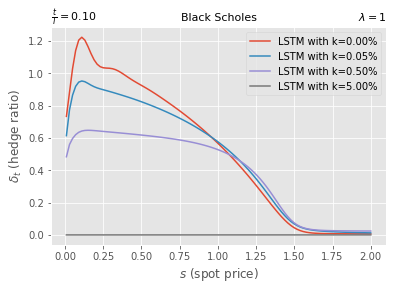

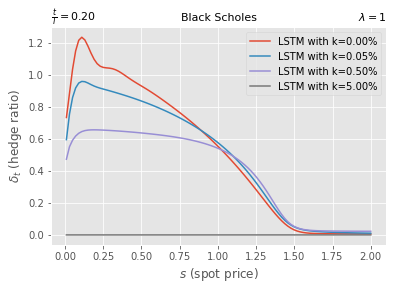

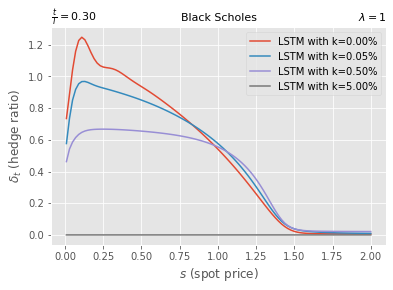

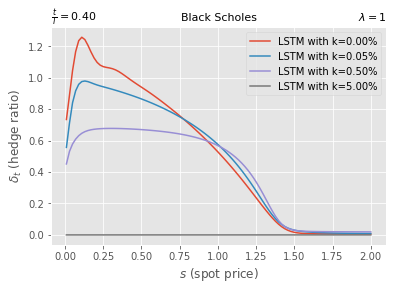

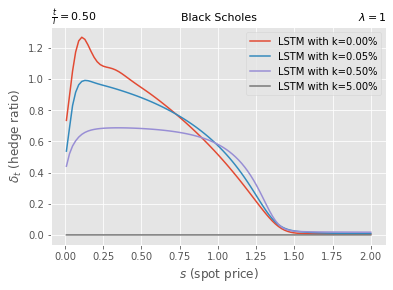

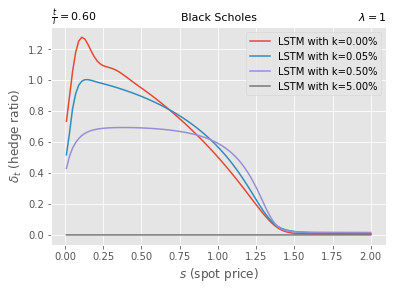

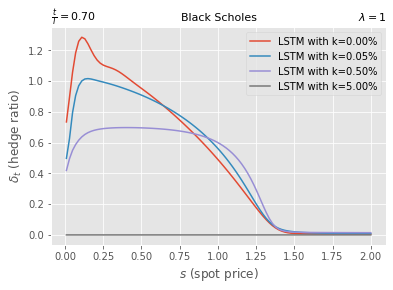

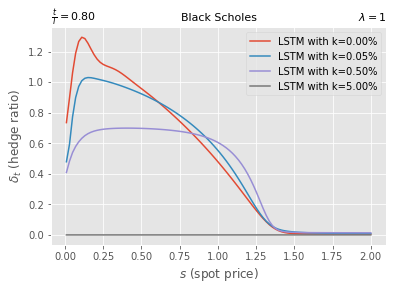

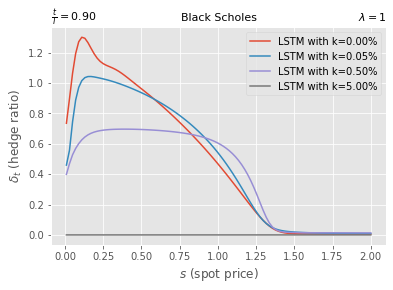

In [ ]:
Lambda=1 
I_in_list=0

for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    Spr = np.linspace(0.01, 2, num=100)
    dSpr = Spr[1]-Spr[0]
    Xpr = np.stack([np.reshape(np.repeat(t, 100), (1,100)), np.reshape(Spr, (1,100))], axis=-1)
    for j in range(len(F_BS[I_in_list])):
      Delta_learn = np.reshape(F_BS[I_in_list][j].predict(Xpr), (100,))
      k = cost_level[j]*100
      plt.plot(Spr, Delta_learn, label=r"LSTM with k=%1.2f" % k + "%")
    plt.xlabel(r"$s$ (spot price)")
    plt.ylabel(r"$\delta_t$ (hedge ratio)")
    plt.title(r'$\frac{t}{T}=$%1.2f' % t, loc='left', fontsize=11)
    plt.title(r'Black Scholes', loc='center', fontsize=11)
    plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
    plt.legend()
    plt.show()

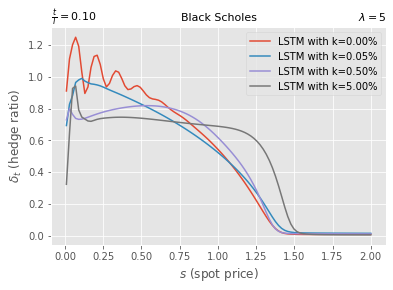

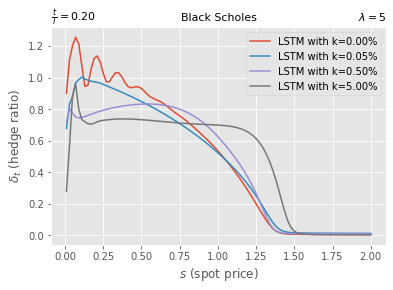

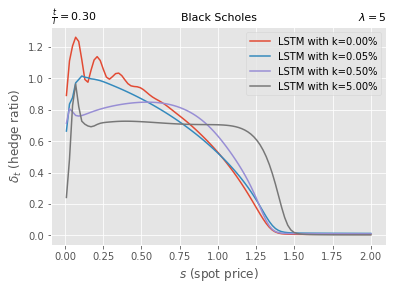

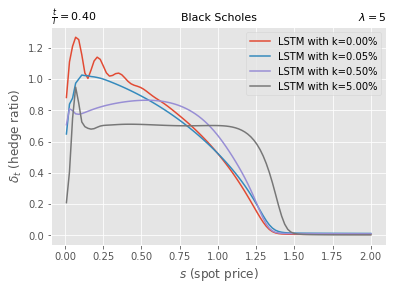

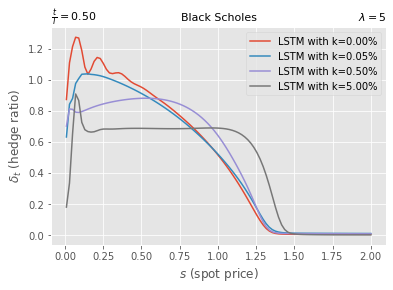

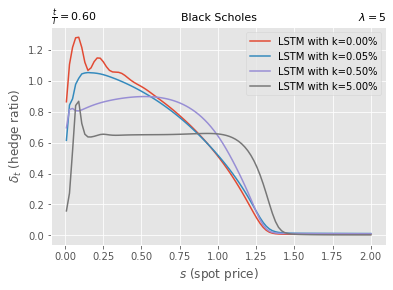

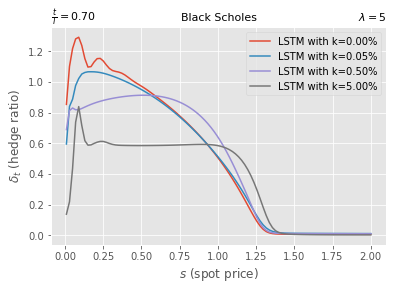

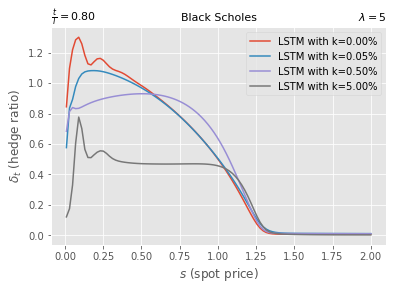

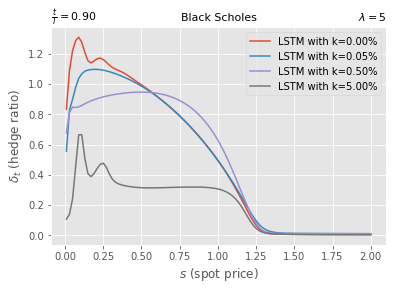

In [ ]:
Lambda=5
I_in_list=1

for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    Spr = np.linspace(0.01, 2, num=100)
    dSpr = Spr[1]-Spr[0]
    Xpr = np.stack([np.reshape(np.repeat(t, 100), (1,100)), np.reshape(Spr, (1,100))], axis=-1)
    for j in range(len(F_BS[I_in_list])):
      Delta_learn = np.reshape(F_BS[I_in_list][j].predict(Xpr), (100,))
      k = cost_level[j]*100
      plt.plot(Spr, Delta_learn, label=r"LSTM with k=%1.2f" % k + "%")
    plt.xlabel(r"$s$ (spot price)")
    plt.ylabel(r"$\delta_t$ (hedge ratio)")
    plt.title(r'$\frac{t}{T}=$%1.2f' % t, loc='left', fontsize=11)
    plt.title(r'Black Scholes', loc='center', fontsize=11)
    plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
    plt.legend()
    plt.show()

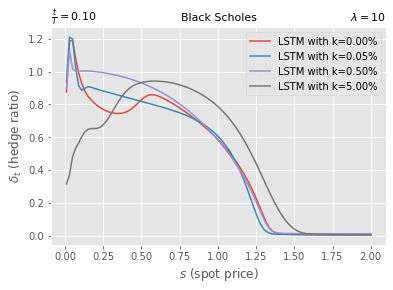

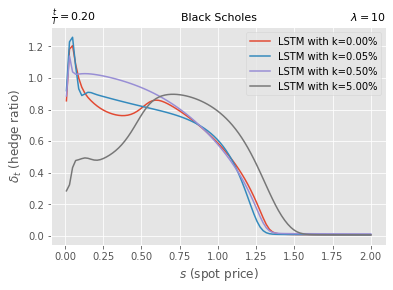

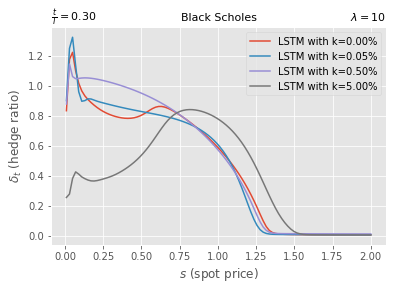

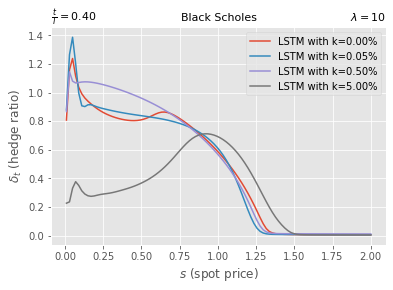

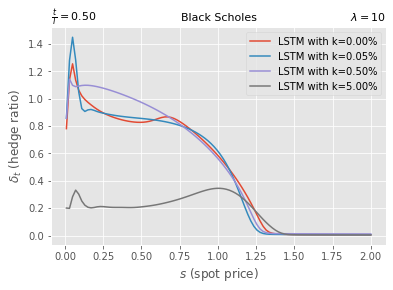

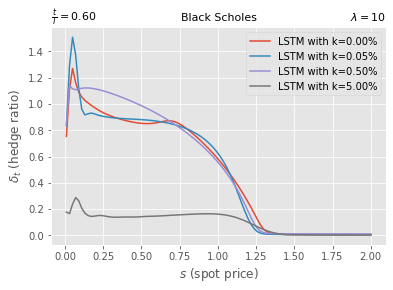

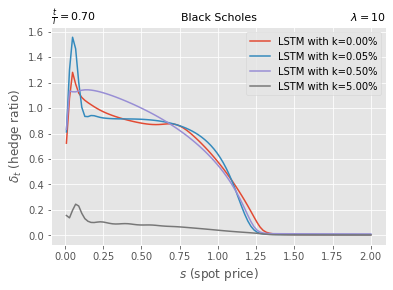

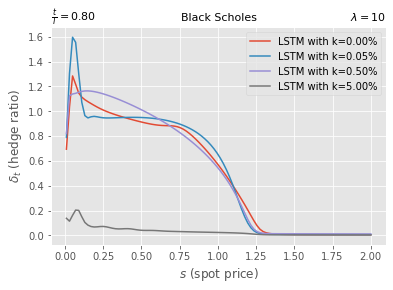

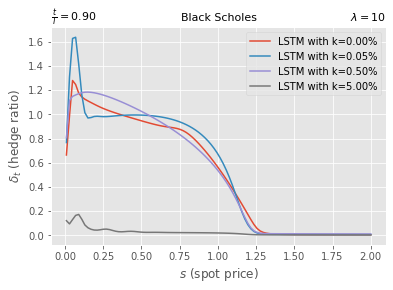

In [ ]:
Lambda=10
I_in_list=2
for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    Spr = np.linspace(0.01, 2, num=100)
    dSpr = Spr[1]-Spr[0]
    Xpr = np.stack([np.reshape(np.repeat(t, 100), (1,100)), np.reshape(Spr, (1,100))], axis=-1)
    for j in range(len(F_BS[I_in_list])):
      Delta_learn = np.reshape(F_BS[I_in_list][j].predict(Xpr), (100,))
      k = cost_level[j]*100
      plt.plot(Spr, Delta_learn, label=r"LSTM with k=%1.2f" % k + "%")
    plt.xlabel(r"$s$ (spot price)")
    plt.ylabel(r"$\delta_t$ (hedge ratio)")
    plt.title(r'$\frac{t}{T}=$%1.2f' % t, loc='left', fontsize=11)
    plt.title(r'Black Scholes', loc='center', fontsize=11)
    plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
    plt.legend()
    plt.show()

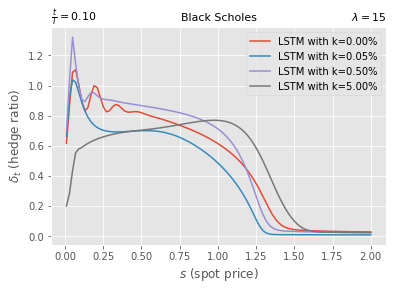

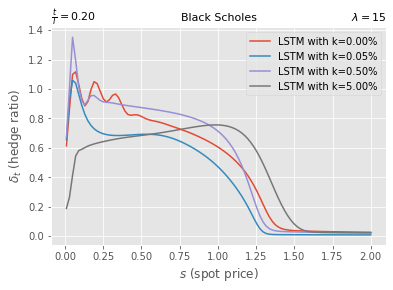

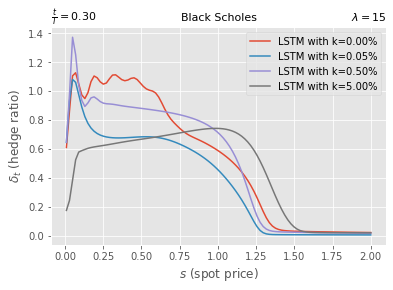

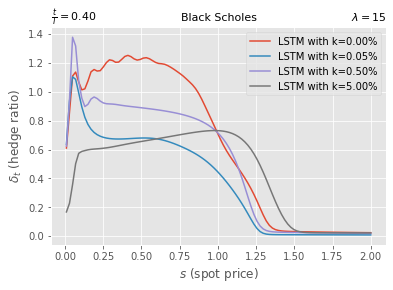

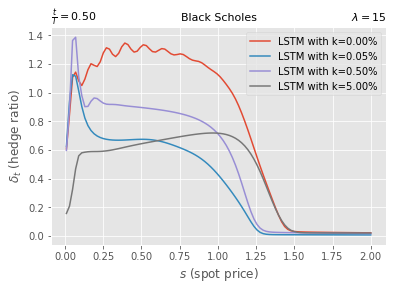

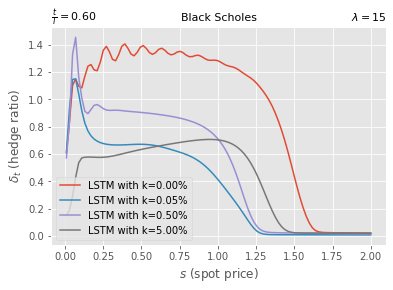

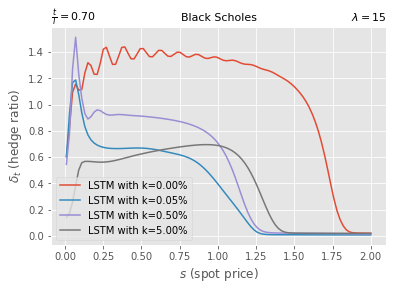

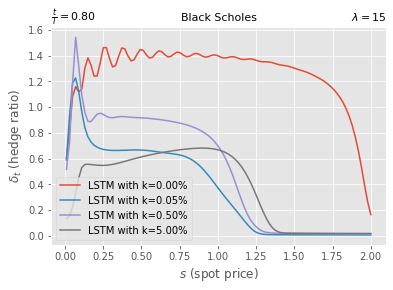

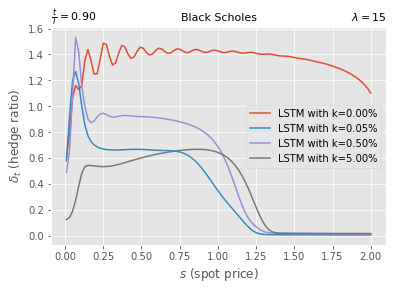

In [ ]:
Lambda=15
I_in_list=3
for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    Spr = np.linspace(0.01, 2, num=100)
    dSpr = Spr[1]-Spr[0]
    Xpr = np.stack([np.reshape(np.repeat(t, 100), (1,100)), np.reshape(Spr, (1,100))], axis=-1)
    for j in range(len(F_BS[I_in_list])):
      Delta_learn = np.reshape(F_BS[I_in_list][j].predict(Xpr), (100,))
      k = cost_level[j]*100
      plt.plot(Spr, Delta_learn, label=r"LSTM with k=%1.2f" % k + "%")
    plt.xlabel(r"$s$ (spot price)")
    plt.ylabel(r"$\delta_t$ (hedge ratio)")
    plt.title(r'$\frac{t}{T}=$%1.2f' % t, loc='left', fontsize=11)
    plt.title(r'Black Scholes', loc='center', fontsize=11)
    plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
    plt.legend()
    plt.show()

## Stock Path simulation

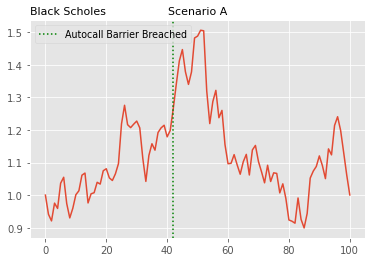

Text(0.5, 1.0, 'Scenario B')

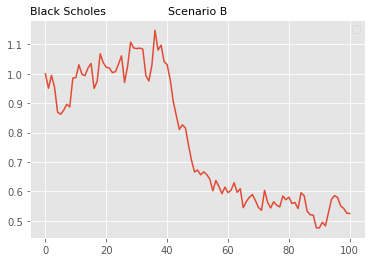

In [ ]:
range_stock_BS = [8, 10]

i  = range_stock_BS[0]
plt.plot(S_BS[i])
#plt.axhline(y = B_AC, color = 'green', linestyle='dotted')
plt.axvline(x = 42, color = 'green', label = 'Autocall Barrier Breached', linestyle='dotted')
plt.legend(loc=2,fontsize=9.5)
plt.title(r'Black Scholes', loc='left', fontsize=11)
plt.title(r'Scenario A', loc='center', fontsize=11)
plt.show()

i  = range_stock_BS[1]
plt.plot(S_BS[i])
plt.legend()
plt.title(r'Black Scholes', loc='left', fontsize=11)
plt.title(r'Scenario B', loc='center', fontsize=11)

## Delta Hedge Ratio for varying t

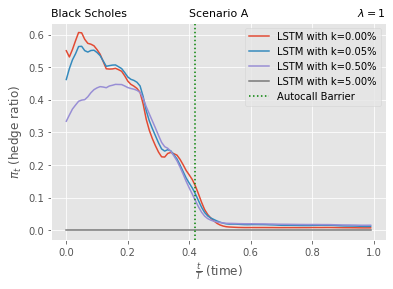

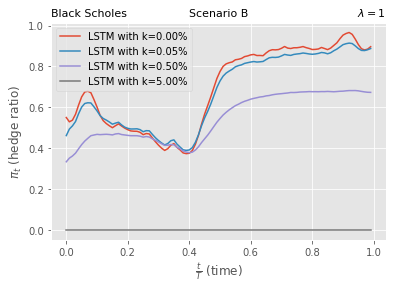

In [ ]:
Lambda=1
I_in_list=0

i  = range_stock_BS[0]
for j in range(len(F_BS)):
    Delta_learn = np.reshape(F_BS[I_in_list][j].predict(X_BS[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_BS[i,:,0], Delta_learn, label=r"LSTM with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\pi_t$ (hedge ratio)")
plt.title(r'Black Scholes', loc='left', fontsize=11)
plt.title(r'Scenario A', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.axvline(x = 0.42, color = 'green', label = 'Autocall Barrier', linestyle='dotted')
plt.legend()
plt.show()

i  = range_stock_BS[1]
for j in range(len(F_BS)):
    Delta_learn = np.reshape(F_BS[I_in_list][j].predict(X_BS[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_BS[i,:,0], Delta_learn, label=r"LSTM with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\pi_t$ (hedge ratio)")
plt.title(r'Black Scholes', loc='left', fontsize=11)
plt.title(r'Scenario B', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.legend()
plt.show()

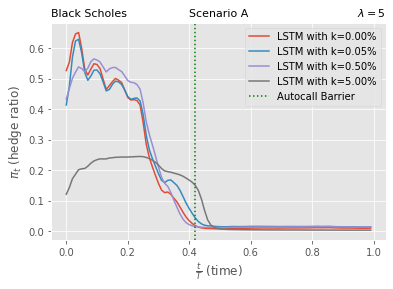

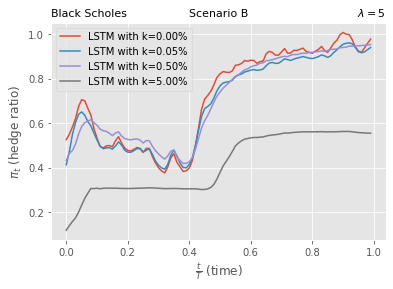

In [ ]:
Lambda=5
I_in_list=1

i  = range_stock_BS[0]
for j in range(len(F_BS)):
    Delta_learn = np.reshape(F_BS[I_in_list][j].predict(X_BS[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_BS[i,:,0], Delta_learn, label=r"LSTM with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\pi_t$ (hedge ratio)")
plt.title(r'Black Scholes', loc='left', fontsize=11)
plt.title(r'Scenario A', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.axvline(x = 0.42, color = 'green', label = 'Autocall Barrier', linestyle='dotted')
plt.legend()
plt.show()

i  = range_stock_BS[1]
for j in range(len(F_BS)):
    Delta_learn = np.reshape(F_BS[I_in_list][j].predict(X_BS[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_BS[i,:,0], Delta_learn, label=r"LSTM with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\pi_t$ (hedge ratio)")
plt.title(r'Black Scholes', loc='left', fontsize=11)
plt.title(r'Scenario B', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.legend()
plt.show()

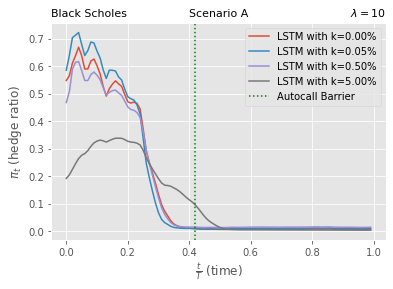

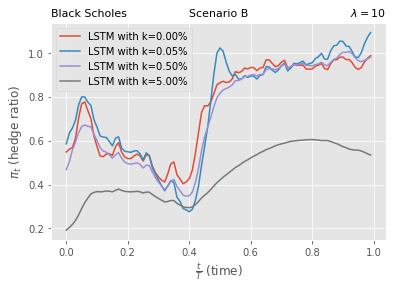

In [ ]:
Lambda=10
I_in_list=2

i  = range_stock_BS[0]
for j in range(len(F_BS)):
    Delta_learn = np.reshape(F_BS[I_in_list][j].predict(X_BS[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_BS[i,:,0], Delta_learn, label=r"LSTM with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\pi_t$ (hedge ratio)")
plt.title(r'Black Scholes', loc='left', fontsize=11)
plt.title(r'Scenario A', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.axvline(x = 0.42, color = 'green', label = 'Autocall Barrier', linestyle='dotted')
plt.legend()
plt.show()

i  = range_stock_BS[1]
for j in range(len(F_BS)):
    Delta_learn = np.reshape(F_BS[I_in_list][j].predict(X_BS[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_BS[i,:,0], Delta_learn, label=r"LSTM with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\pi_t$ (hedge ratio)")
plt.title(r'Black Scholes', loc='left', fontsize=11)
plt.title(r'Scenario B', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.legend()
plt.show()

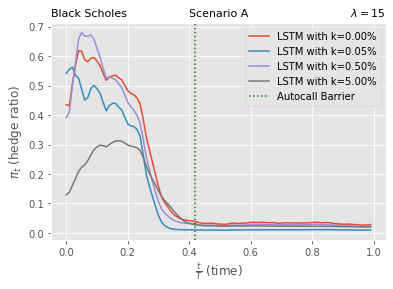

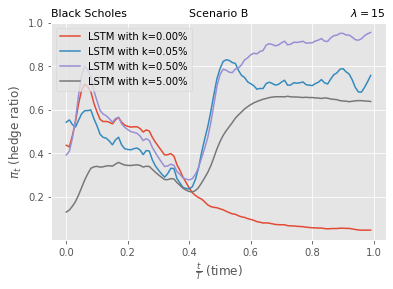

In [ ]:
Lambda=15
I_in_list=3

i  = range_stock_BS[0]
for j in range(len(F_BS)):
    Delta_learn = np.reshape(F_BS[I_in_list][j].predict(X_BS[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_BS[i,:,0], Delta_learn, label=r"LSTM with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\pi_t$ (hedge ratio)")
plt.title(r'Black Scholes', loc='left', fontsize=11)
plt.title(r'Scenario A', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.axvline(x = 0.42, color = 'green', label = 'Autocall Barrier', linestyle='dotted')
plt.legend()
plt.show()

i  = range_stock_BS[1]
for j in range(len(F_BS)):
    Delta_learn = np.reshape(F_BS[I_in_list][j].predict(X_BS[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_BS[i,:,0], Delta_learn, label=r"LSTM with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\pi_t$ (hedge ratio)")
plt.title(r'Black Scholes', loc='left', fontsize=11)
plt.title(r'Scenario B', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.legend()
plt.show()

# Heston

## Simulating Stock Path

We set the parameter values as before:

In [ ]:
###Heston
kappa =3
theta = 0.04
v_0 =  sigma**2 # v_t is variance, hence sigma 0 squared
xi = 0.6
r = 0
S_0 = 1
N = 100000
steps = 101
T = 100
rho = -0.8
prices= generate_heston_paths(S_0, 1, r, kappa, theta,v_0, rho, xi, steps, N)

And we generate the training samples:

In [ ]:
Ti = np.tile(np.linspace(0, 1, T+1)[0:T], (N, 1))
S_HEST = prices
dS_HEST = np.diff(S_HEST, 1, 1)
X_HEST = np.stack([Ti, S_HEST[:,0:T]], axis=-1)

## Training Network

Utility Indifference pricing with Exponential Utility:

\begin{align} \label{eq:exp_utility_function}
-U_\lambda(x):=\frac{1}{\lambda}\exp{(-\lambda x)},\qquad x \in \mathbb{R}
\end{align} 

We used a network $f$ such that
\begin{equation*}
f \in \mathcal{N}_4(2,100,100,100,1; \mathrm{ReLU},\mathrm{ReLU},\mathrm{ReLU},\mathrm{softplus}).
\end{equation*}

In [ ]:
F1_HEST, F5_HEST, F10_HEST, F15_HEST = [], [], [], []
F_HEST = [F1_HEST, F5_HEST, F10_HEST, F15_HEST]
LSTM1_HEST, LSTM5_HEST, LSTM10_HEST, LSTM15_HEST = [], [], [], []
LSTM_HEST = [LSTM1_HEST,LSTM5_HEST,LSTM10_HEST,LSTM15_HEST]
for i in range(len(risk_aversion)): #range lambda
  for j in range(len(risk_aversion)): #range cost level
    prices = keras.layers.Input(shape=(T,2))
    LSTM_HEST[i].append(keras.layers.LSTM(units, return_sequences=True))
    layer_dense = keras.layers.Dense(1, activation="softplus")
    y = LSTM_HEST[i][j](prices)
    hedges = layer_dense(y)
    F_HEST[i].append(keras.models.Model(inputs=prices, outputs=hedges))


In [ ]:
i, j = 0, 0
F_HEST[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_HEST[i][j].fit(X_HEST, dS_HEST, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_HEST[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_HEST[i][j].fit(X_HEST,dS_HEST,batch_size=batch_size,epochs=epochs_slow)

i, j = 0, 1
F_HEST[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_HEST[i][j].fit(X_HEST, dS_HEST, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_HEST[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_HEST[i][j].fit(X_HEST,dS_HEST,batch_size=batch_size,epochs=epochs_slow)

i, j = 0, 2
F_HEST[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_HEST[i][j].fit(X_HEST, dS_HEST, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_HEST[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_HEST[i][j].fit(X_HEST,dS_HEST,batch_size=batch_size,epochs=epochs_slow)

i, j = 0, 3
F_HEST[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_HEST[i][j].fit(X_HEST, dS_HEST, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_HEST[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_HEST[i][j].fit(X_HEST,dS_HEST,batch_size=batch_size,epochs=epochs_slow)

i, j = 1, 0
F_HEST[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_HEST[i][j].fit(X_HEST, dS_HEST, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_HEST[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_HEST[i][j].fit(X_HEST,dS_HEST,batch_size=batch_size,epochs=epochs_slow)

i, j = 1, 1
F_HEST[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_HEST[i][j].fit(X_HEST, dS_HEST, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_HEST[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_HEST[i][j].fit(X_HEST,dS_HEST,batch_size=batch_size,epochs=epochs_slow)

i, j = 1, 2
F_HEST[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_HEST[i][j].fit(X_HEST, dS_HEST, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_HEST[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_HEST[i][j].fit(X_HEST,dS_HEST,batch_size=batch_size,epochs=epochs_slow)

i, j = 1, 3
F_HEST[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_HEST[i][j].fit(X_HEST, dS_HEST, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_HEST[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_HEST[i][j].fit(X_HEST,dS_HEST,batch_size=batch_size,epochs=epochs_slow)

i, j = 2, 0
F_HEST[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_HEST[i][j].fit(X_HEST, dS_HEST, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_HEST[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_HEST[i][j].fit(X_HEST,dS_HEST,batch_size=batch_size,epochs=epochs_slow)

i, j = 2, 1
F_HEST[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_HEST[i][j].fit(X_HEST, dS_HEST, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_HEST[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_HEST[i][j].fit(X_HEST,dS_HEST,batch_size=batch_size,epochs=epochs_slow)

i, j = 2, 2
F_HEST[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_HEST[i][j].fit(X_HEST, dS_HEST, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_HEST[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_HEST[i][j].fit(X_HEST,dS_HEST,batch_size=batch_size,epochs=epochs_slow)

i, j = 2, 3
F_HEST[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_HEST[i][j].fit(X_HEST, dS_HEST, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_HEST[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_HEST[i][j].fit(X_HEST,dS_HEST,batch_size=batch_size,epochs=epochs_slow)

i, j = 3, 0
F_HEST[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_HEST[i][j].fit(X_HEST, dS_HEST, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_HEST[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_HEST[i][j].fit(X_HEST,dS_HEST,batch_size=batch_size,epochs=epochs_slow)

i, j = 3, 1
F_HEST[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_HEST[i][j].fit(X_HEST, dS_HEST, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_HEST[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_HEST[i][j].fit(X_HEST,dS_HEST,batch_size=batch_size,epochs=epochs_slow)

i, j = 3, 2
F_HEST[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_HEST[i][j].fit(X_HEST, dS_HEST, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_HEST[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_HEST[i][j].fit(X_HEST,dS_HEST,batch_size=batch_size,epochs=epochs_slow)

i, j = 3, 3
F_HEST[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_HEST[i][j].fit(X_HEST, dS_HEST, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_HEST[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_HEST[i][j].fit(X_HEST,dS_HEST,batch_size=batch_size,epochs=epochs_slow)

Epoch 1/10
20/20 [==============================] - 8s 30ms/step - loss: 1.5554
Epoch 2/10
20/20 [==============================] - 1s 29ms/step - loss: 1.5515
Epoch 3/10
20/20 [==============================] - 1s 29ms/step - loss: 1.5479
Epoch 4/10
20/20 [==============================] - 1s 30ms/step - loss: 1.5492
Epoch 5/10
20/20 [==============================] - 1s 29ms/step - loss: 1.5468
Epoch 6/10
20/20 [==============================] - 1s 30ms/step - loss: 1.5463
Epoch 7/10
20/20 [==============================] - 1s 30ms/step - loss: 1.5462
Epoch 8/10
20/20 [==============================] - 1s 29ms/step - loss: 1.5461
Epoch 9/10
20/20 [==============================] - 1s 29ms/step - loss: 1.5462
Epoch 10/10
20/20 [==============================] - 1s 29ms/step - loss: 1.5461
Epoch 1/10
20/20 [==============================] - 2s 29ms/step - loss: 1.5457
Epoch 2/10
20/20 [==============================] - 1s 29ms/step - loss: 1.5458
Epoch 3/10
20/20 [=====================

## Indifference pricing

In [ ]:
for i in range(len(F_HEST)):
  for j in range(len(F_HEST[i])):
    loss = F_HEST[i][j].evaluate(X_HEST,dS_HEST)
    result = (1/risk_aversion[i] * np.log(risk_aversion[i]*np.float_(loss)+1))
    k_cost = cost_level[j]*100
    print(r'Risk Aversion=%1.f' % risk_aversion[i], r'Cost level=%1.2f' % k_cost + "%", r'Indiff pricing=%1.22f' % result)

3125/3125 [==============================] - 10s 3ms/step - loss: 1.5444
Risk Aversion=1 Cost level=0.00% Indiff pricing=0.9338844087087173617689
3125/3125 [==============================] - 10s 3ms/step - loss: 1.5472
Risk Aversion=1 Cost level=0.05% Indiff pricing=0.9349756549058774179883
3125/3125 [==============================] - 10s 3ms/step - loss: 1.5616
Risk Aversion=1 Cost level=0.50% Indiff pricing=0.9406295850293947546916
3125/3125 [==============================] - 10s 3ms/step - loss: 1.5780
Risk Aversion=1 Cost level=5.00% Indiff pricing=0.9470064400824819150770
3125/3125 [==============================] - 9s 3ms/step - loss: 21.8796
Risk Aversion=5 Cost level=0.00% Indiff pricing=0.9408180800383381114926
3125/3125 [==============================] - 11s 3ms/step - loss: 21.9678
Risk Aversion=5 Cost level=0.05% Indiff pricing=0.9416161194364189856998
3125/3125 [==============================] - 10s 3ms/step - loss: 22.9309
Risk Aversion=5 Cost level=0.50% Indiff pricing=0

## Delta Hedge Ratio for varying S

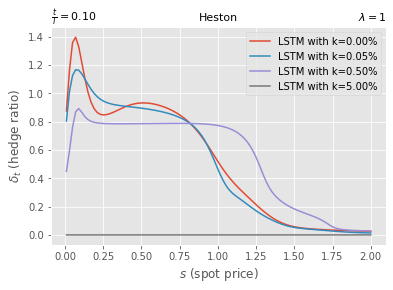

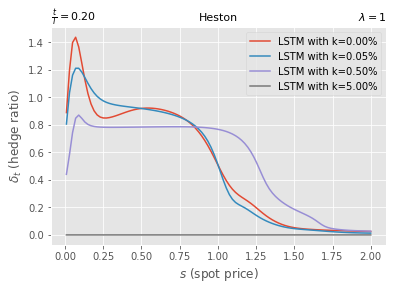

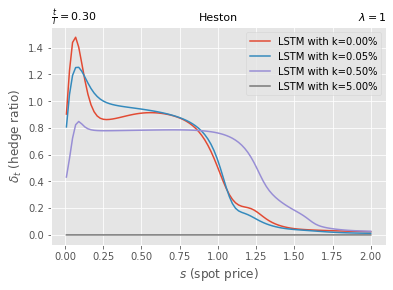

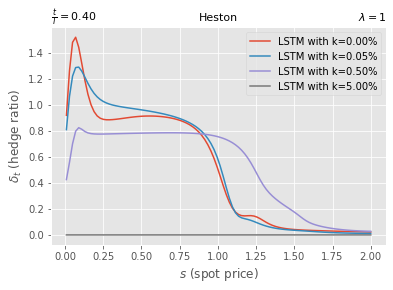

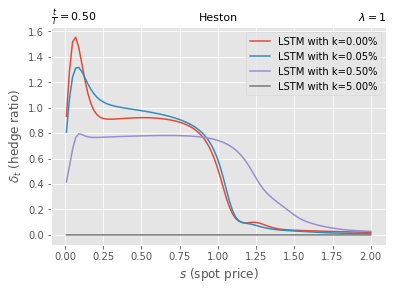

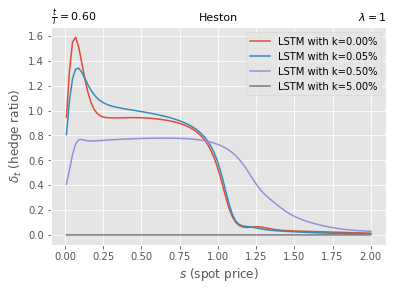

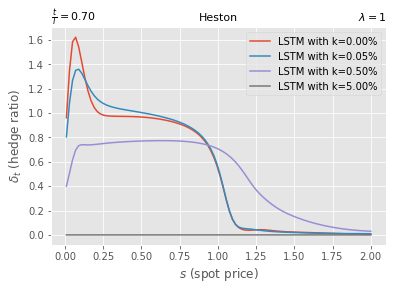

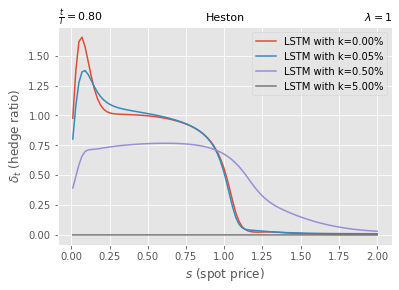

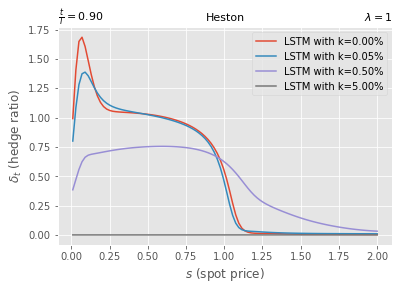

In [ ]:
Lambda=1
I_in_list=0

for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    Spr = np.linspace(0.01, 2, num=100)
    dSpr = Spr[1]-Spr[0]
    Xpr = np.stack([np.reshape(np.repeat(t, 100), (1,100)), np.reshape(Spr, (1,100))], axis=-1)
    for j in range(len(F_HEST[I_in_list])):
        Delta = np.reshape(F_HEST[I_in_list][j].predict(Xpr), (100,))
        k = cost_level[j]*100
        plt.plot(Spr, Delta, label=r"LSTM with k=%1.2f" % k + "%")
    plt.xlabel(r"$s$ (spot price)")
    plt.ylabel(r"$\delta_t$ (hedge ratio)")
    plt.title(r'$\frac{t}{T}=$%1.2f' % t, loc='left', fontsize=11)
    plt.title(r'Heston', loc='center', fontsize=11)
    plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
    plt.legend()
    plt.show()

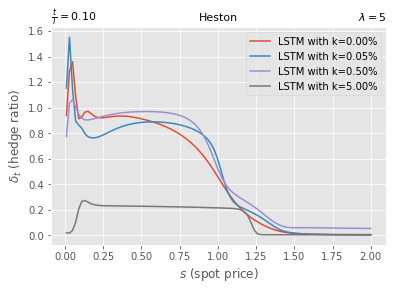

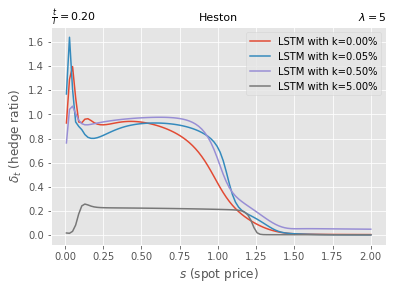

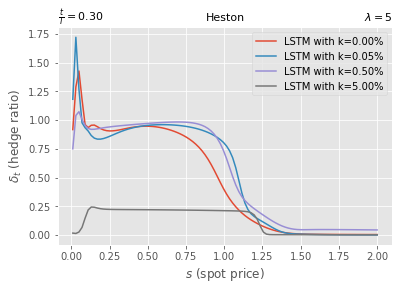

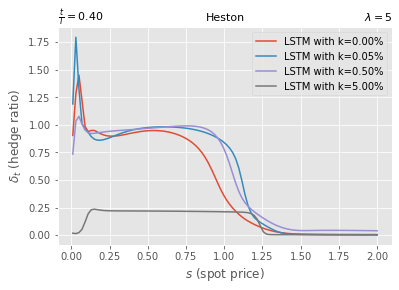

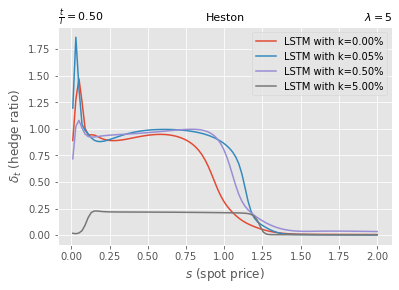

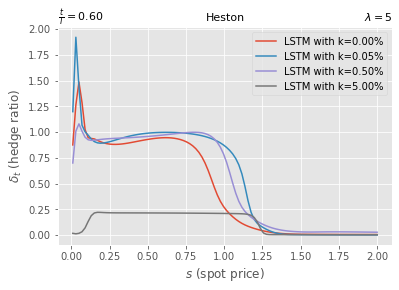

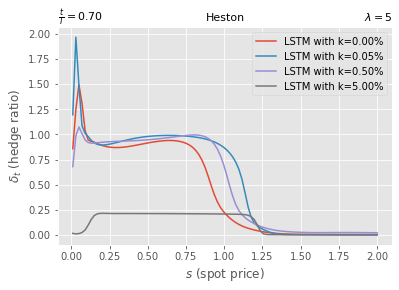

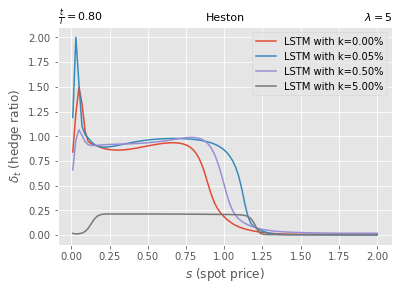

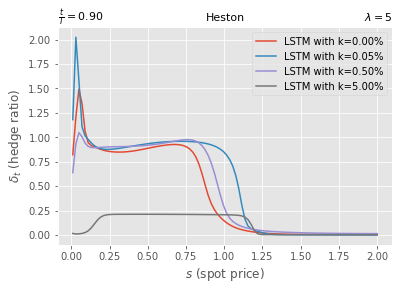

In [ ]:
Lambda=5
I_in_list=1

for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    Spr = np.linspace(0.01, 2, num=100)
    dSpr = Spr[1]-Spr[0]
    Xpr = np.stack([np.reshape(np.repeat(t, 100), (1,100)), np.reshape(Spr, (1,100))], axis=-1)
    for j in range(len(F_HEST[I_in_list])):
        Delta = np.reshape(F_HEST[I_in_list][j].predict(Xpr), (100,))
        k = cost_level[j]*100
        plt.plot(Spr, Delta, label=r"LSTM with k=%1.2f" % k + "%")
    plt.xlabel(r"$s$ (spot price)")
    plt.ylabel(r"$\delta_t$ (hedge ratio)")
    plt.title(r'$\frac{t}{T}=$%1.2f' % t, loc='left', fontsize=11)
    plt.title(r'Heston', loc='center', fontsize=11)
    plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
    plt.legend()
    plt.show()

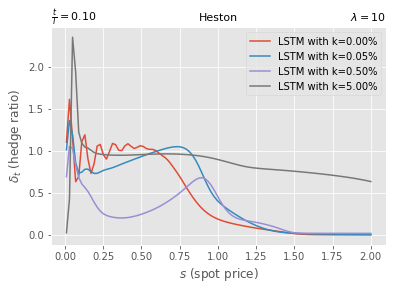

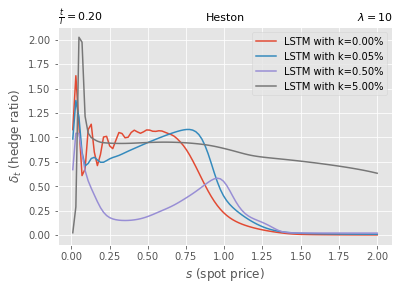

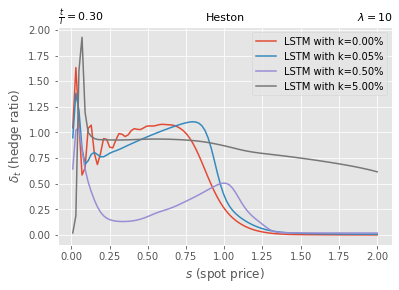

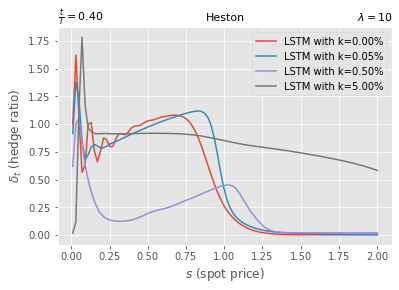

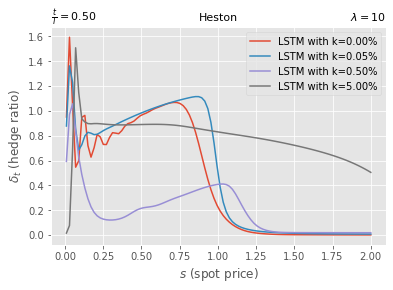

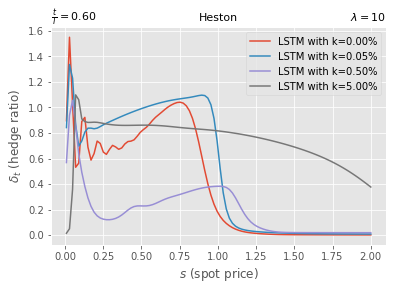

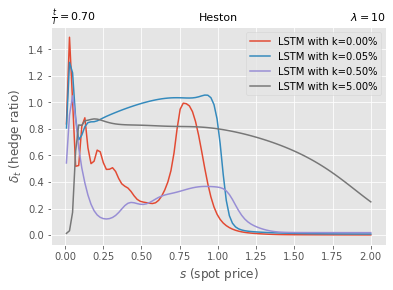

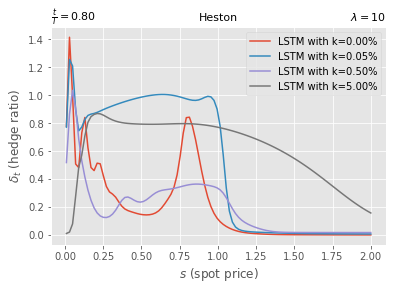

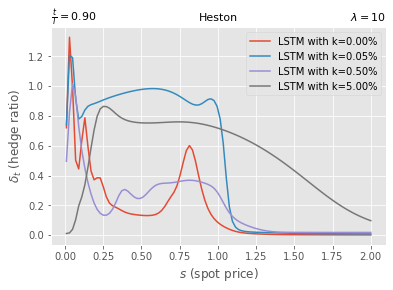

In [ ]:
Lambda=10
I_in_list=2

for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    Spr = np.linspace(0.01, 2, num=100)
    dSpr = Spr[1]-Spr[0]
    Xpr = np.stack([np.reshape(np.repeat(t, 100), (1,100)), np.reshape(Spr, (1,100))], axis=-1)
    for j in range(len(F_HEST[I_in_list])):
        Delta = np.reshape(F_HEST[I_in_list][j].predict(Xpr), (100,))
        k = cost_level[j]*100
        plt.plot(Spr, Delta, label=r"LSTM with k=%1.2f" % k + "%")
    plt.xlabel(r"$s$ (spot price)")
    plt.ylabel(r"$\delta_t$ (hedge ratio)")
    plt.title(r'$\frac{t}{T}=$%1.2f' % t, loc='left', fontsize=11)
    plt.title(r'Heston', loc='center', fontsize=11)
    plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
    plt.legend()
    plt.show()

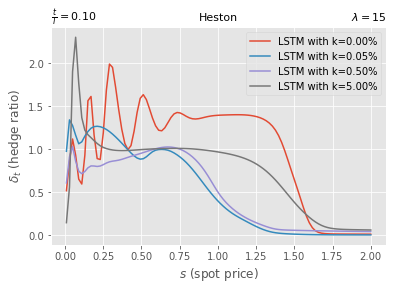

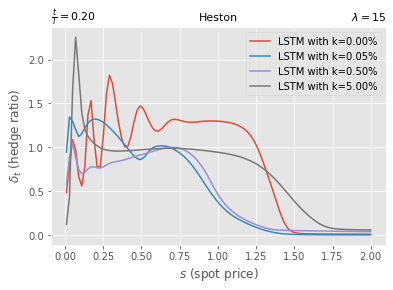

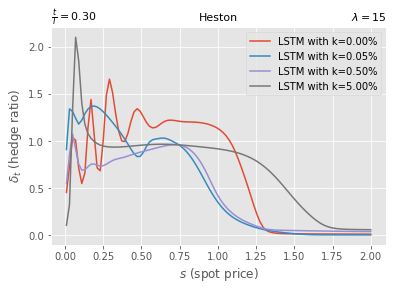

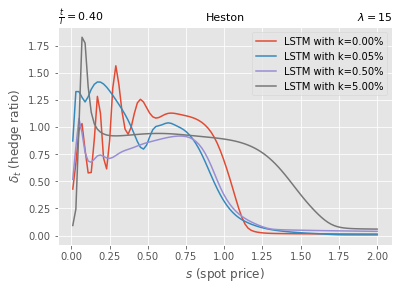

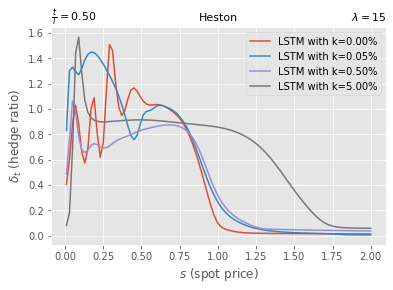

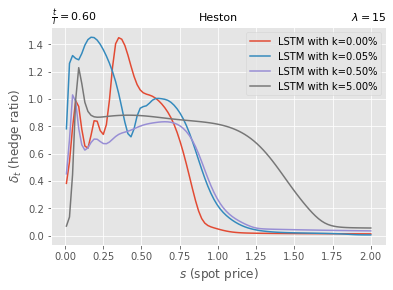

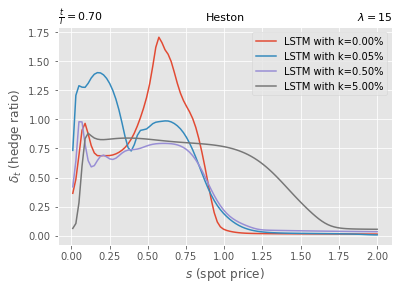

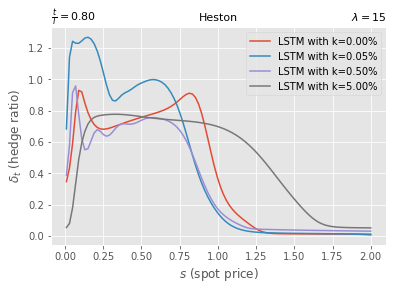

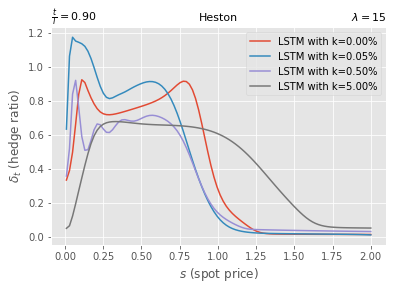

In [ ]:
Lambda=15
I_in_list=3

for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    Spr = np.linspace(0.01, 2, num=100)
    dSpr = Spr[1]-Spr[0]
    Xpr = np.stack([np.reshape(np.repeat(t, 100), (1,100)), np.reshape(Spr, (1,100))], axis=-1)
    for j in range(len(F_HEST[I_in_list])):
        Delta = np.reshape(F_HEST[I_in_list][j].predict(Xpr), (100,))
        k = cost_level[j]*100
        plt.plot(Spr, Delta, label=r"LSTM with k=%1.2f" % k + "%")
    plt.xlabel(r"$s$ (spot price)")
    plt.ylabel(r"$\delta_t$ (hedge ratio)")
    plt.title(r'$\frac{t}{T}=$%1.2f' % t, loc='left', fontsize=11)
    plt.title(r'Heston', loc='center', fontsize=11)
    plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
    plt.legend()
    plt.show()

## Stock Path simulation

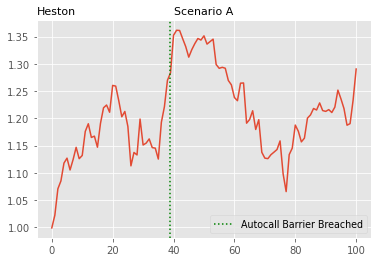

Text(0.5, 1.0, 'Scenario B')

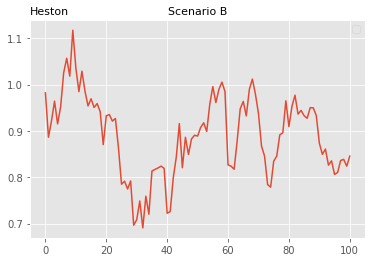

In [ ]:
range_stock_HEST = [3,4]

i  = range_stock_HEST[0]
plt.plot(S_HEST[i])
#plt.axhline(y = B_AC, color = 'green', linestyle='dotted')
plt.axvline(x = 39, color = 'green', label = 'Autocall Barrier Breached', linestyle='dotted')
plt.legend(loc=4,fontsize=9.5)
plt.title(r'Heston', loc='left', fontsize=11)
plt.title(r'Scenario A', loc='center', fontsize=11)
plt.show()

i  = range_stock_HEST[1]
plt.plot(S_HEST[i])
plt.legend()
plt.title(r'Heston', loc='left', fontsize=11)
plt.title(r'Scenario B', loc='center', fontsize=11)

## Delta Hedge Ratio for varying t

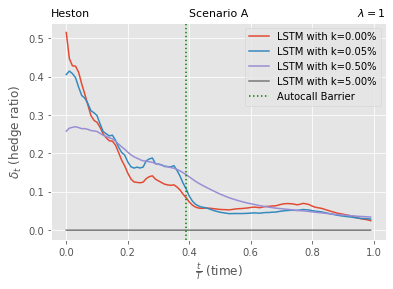

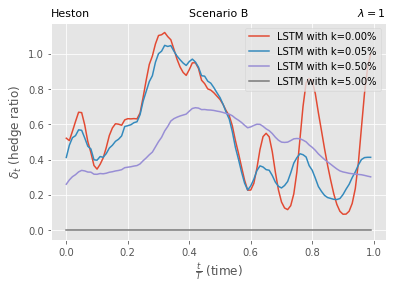

In [ ]:
Lambda=1
I_in_list=0

i  = range_stock_HEST[0]
for j in range(len(F_HEST)):
    Delta_learn = np.reshape(F_HEST[I_in_list][j].predict(X_HEST[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_HEST[i,:,0], Delta_learn, label=r"LSTM with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\delta_t$ (hedge ratio)")
plt.title(r'Heston', loc='left', fontsize=11)
plt.title(r'Scenario A', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.axvline(x = 0.39, color = 'green', label = 'Autocall Barrier', linestyle='dotted')
plt.legend()
plt.show()

i  = range_stock_HEST[1]
for j in range(len(F_HEST)):
    Delta_learn = np.reshape(F_HEST[I_in_list][j].predict(X_HEST[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_HEST[i,:,0], Delta_learn, label=r"LSTM with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\delta_t$ (hedge ratio)")
plt.title(r'Heston', loc='left', fontsize=11)
plt.title(r'Scenario B', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.legend()
plt.show()

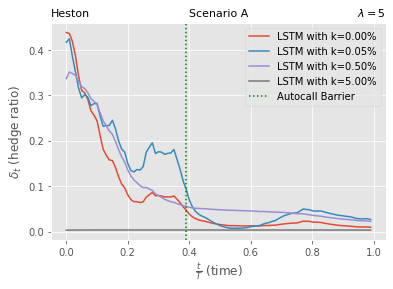

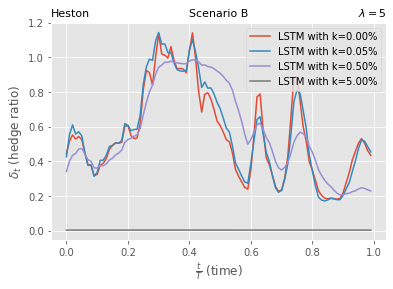

In [ ]:
Lambda=5
I_in_list=1

i  = range_stock_HEST[0]
for j in range(len(F_HEST)):
    Delta_learn = np.reshape(F_HEST[I_in_list][j].predict(X_HEST[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_HEST[i,:,0], Delta_learn, label=r"LSTM with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\delta_t$ (hedge ratio)")
plt.title(r'Heston', loc='left', fontsize=11)
plt.title(r'Scenario A', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.axvline(x = 0.39, color = 'green', label = 'Autocall Barrier', linestyle='dotted')
plt.legend()
plt.show()

i  = range_stock_HEST[1]
for j in range(len(F_HEST)):
    Delta_learn = np.reshape(F_HEST[I_in_list][j].predict(X_HEST[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_HEST[i,:,0], Delta_learn, label=r"LSTM with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\delta_t$ (hedge ratio)")
plt.title(r'Heston', loc='left', fontsize=11)
plt.title(r'Scenario B', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.legend()
plt.show()

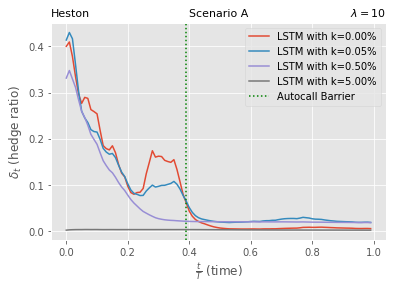

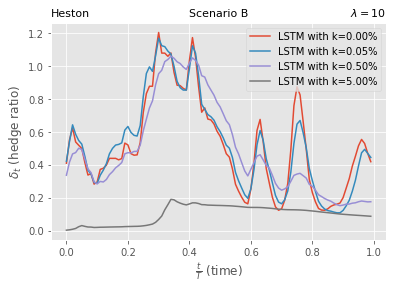

In [ ]:
Lambda=10
I_in_list=2

i  = range_stock_HEST[0]
for j in range(len(F_HEST)):
    Delta_learn = np.reshape(F_HEST[I_in_list][j].predict(X_HEST[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_HEST[i,:,0], Delta_learn, label=r"LSTM with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\delta_t$ (hedge ratio)")
plt.title(r'Heston', loc='left', fontsize=11)
plt.title(r'Scenario A', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.axvline(x = 0.39, color = 'green', label = 'Autocall Barrier', linestyle='dotted')
plt.legend()
plt.show()

i  = range_stock_HEST[1]
for j in range(len(F_HEST)):
    Delta_learn = np.reshape(F_HEST[I_in_list][j].predict(X_HEST[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_HEST[i,:,0], Delta_learn, label=r"LSTM with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\delta_t$ (hedge ratio)")
plt.title(r'Heston', loc='left', fontsize=11)
plt.title(r'Scenario B', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.legend()
plt.show()

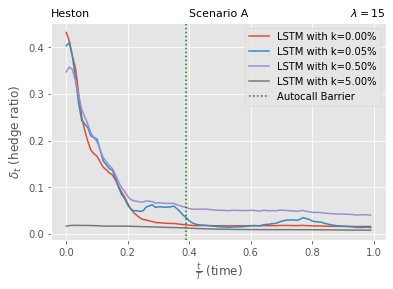

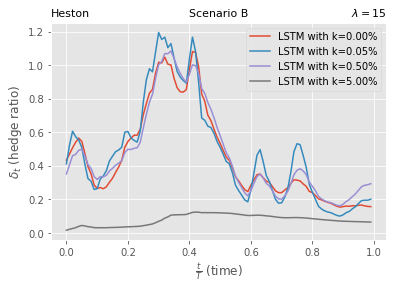

In [ ]:
Lambda=15
I_in_list=3

i  = range_stock_HEST[0]
for j in range(len(F_HEST)):
    Delta_learn = np.reshape(F_HEST[I_in_list][j].predict(X_HEST[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_HEST[i,:,0], Delta_learn, label=r"LSTM with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\delta_t$ (hedge ratio)")
plt.title(r'Heston', loc='left', fontsize=11)
plt.title(r'Scenario A', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.axvline(x = 0.39, color = 'green', label = 'Autocall Barrier', linestyle='dotted')
plt.legend()
plt.show()

i  = range_stock_HEST[1]
for j in range(len(F_HEST)):
    Delta_learn = np.reshape(F_HEST[I_in_list][j].predict(X_HEST[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_HEST[i,:,0], Delta_learn, label=r"LSTM with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\delta_t$ (hedge ratio)")
plt.title(r'Heston', loc='left', fontsize=11)
plt.title(r'Scenario B', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.legend()
plt.show()

# Rough Volatility

## Mounting drive and importing libs

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/Py scripts

# List files to make sure we're in the expected directory.
# Your output will look different, showing your own Drive files here.
!ls
import sys
sys.path.insert(0,"/content/gdrive/MyDrive/Py scripts/rbergomi.py")
sys.path.insert(0,"/content/gdrive/MyDrive/Py scripts/utils.py")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Py scripts
__pycache__  rbergomi.py  utils.py


In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib import pyplot as plt
from rbergomi import rBergomi
from utils import bsinv
vec_bsinv = np.vectorize(bsinv)
import numpy.random as npr
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as kb
plt.style.use('ggplot')

In [ ]:
class Rough_Bergomi:
    
    def __init__(self, S_0, T, a, rho,xi): #N=number of sims
        self.S_0 = S_0
        self.T = T
        self.a = a
        self.rho = rho
        self.xi = xi
        
    def simulate_stock_price(self, steps, N):
        rB = rBergomi(steps, N, self.T, self.a)
        np.random.seed(0)
        dW1 = rB.dW1()
        dW2 = rB.dW2()
        Y = rB.Y(dW1)
        dB = rB.dB(dW1, dW2, rho)
        V = rB.V(Y, xi, eta) 
        S = rB.S(V, dB,S_0)
        return S


## Simulating Stock Path

We set the parameter values as before:

In [ ]:
T = 100
S_0 = 1

npr.seed(12345)
N = 100000
Ti = np.tile(np.linspace(0, 1, T+1)[0:T], (N, 1))
xi = 0.6
r = 0
steps = 100
rho = -0.8
T_mat = 1

In [ ]:
a, eta = -0.43, 1.9
r_bergomi = Rough_Bergomi(S_0, T_mat, a, rho,xi)
S_BERG = r_bergomi.simulate_stock_price(steps, N)
dS_BERG = np.diff(S_BERG, 1, 1)
X_BERG = np.stack([Ti, S_BERG[:,0:T]], axis=-1)

## Training Network

Utility Indifference pricing with Exponential Utility:

\begin{align} \label{eq:exp_utility_function}
-U_\lambda(x):=\frac{1}{\lambda}\exp{(-\lambda x)},\qquad x \in \mathbb{R}
\end{align} 

We used a network $f$ such that
\begin{equation*}
f \in \mathcal{N}_4(2,100,100,100,1; \mathrm{ReLU},\mathrm{ReLU},\mathrm{ReLU},\mathrm{softplus}).
\end{equation*}

In [ ]:
F1_BERG, F5_BERG, F10_BERG, F15_BERG = [], [], [], []
F_BERG = [F1_BERG, F5_BERG, F10_BERG, F15_BERG]
LSTM1_BERG, LSTM5_BERG, LSTM10_BERG, LSTM15_BERG = [], [], [], []
LSTM_BERG = [LSTM1_BERG,LSTM5_BERG,LSTM10_BERG,LSTM15_BERG]
for i in range(len(risk_aversion)): #range lambda
  for j in range(len(risk_aversion)): #range cost level
    prices = keras.layers.Input(shape=(T,2))
    LSTM_BERG[i].append(keras.layers.LSTM(units, return_sequences=True))
    layer_dense = keras.layers.Dense(1, activation="softplus")
    y = LSTM_BERG[i][j](prices)
    hedges = layer_dense(y)
    F_BERG[i].append(keras.models.Model(inputs=prices, outputs=hedges))


In [ ]:
i, j = 0, 0
F_BERG[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BERG[i][j].fit(X_BERG, dS_BERG, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_BERG[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_BERG[i][j].fit(X_BERG,dS_BERG,batch_size=batch_size,epochs=epochs_slow)

i, j = 0, 1
F_BERG[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BERG[i][j].fit(X_BERG, dS_BERG, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_BERG[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_BERG[i][j].fit(X_BERG,dS_BERG,batch_size=batch_size,epochs=epochs_slow)

i, j = 0, 2
F_BERG[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BERG[i][j].fit(X_BERG, dS_BERG, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_BERG[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_BERG[i][j].fit(X_BERG,dS_BERG,batch_size=batch_size,epochs=epochs_slow)

i, j = 0, 3
F_BERG[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BERG[i][j].fit(X_BERG, dS_BERG, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_BERG[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_BERG[i][j].fit(X_BERG,dS_BERG,batch_size=batch_size,epochs=epochs_slow)

i, j = 1, 0
F_BERG[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BERG[i][j].fit(X_BERG, dS_BERG, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_BERG[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_BERG[i][j].fit(X_BERG,dS_BERG,batch_size=batch_size,epochs=epochs_slow)

i, j = 1, 1
F_BERG[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BERG[i][j].fit(X_BERG, dS_BERG, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_BERG[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_BERG[i][j].fit(X_BERG,dS_BERG,batch_size=batch_size,epochs=epochs_slow)

i, j = 1, 2
F_BERG[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BERG[i][j].fit(X_BERG, dS_BERG, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_BERG[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_BERG[i][j].fit(X_BERG,dS_BERG,batch_size=batch_size,epochs=epochs_slow)

i, j = 1, 3
F_BERG[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BERG[i][j].fit(X_BERG, dS_BERG, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_BERG[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_BERG[i][j].fit(X_BERG,dS_BERG,batch_size=batch_size,epochs=epochs_slow)

i, j = 2, 0
F_BERG[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BERG[i][j].fit(X_BERG, dS_BERG, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_BERG[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_BERG[i][j].fit(X_BERG,dS_BERG,batch_size=batch_size,epochs=epochs_slow)

i, j = 2, 1
F_BERG[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BERG[i][j].fit(X_BERG, dS_BERG, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_BERG[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_BERG[i][j].fit(X_BERG,dS_BERG,batch_size=batch_size,epochs=epochs_slow)

i, j = 2, 2
F_BERG[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BERG[i][j].fit(X_BERG, dS_BERG, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_BERG[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_BERG[i][j].fit(X_BERG,dS_BERG,batch_size=batch_size,epochs=epochs_slow)

i, j = 2, 3
F_BERG[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BERG[i][j].fit(X_BERG, dS_BERG, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_BERG[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_BERG[i][j].fit(X_BERG,dS_BERG,batch_size=batch_size,epochs=epochs_slow)

i, j = 3, 0
F_BERG[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BERG[i][j].fit(X_BERG, dS_BERG, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_BERG[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_BERG[i][j].fit(X_BERG,dS_BERG,batch_size=batch_size,epochs=epochs_slow)

i, j = 3, 1
F_BERG[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BERG[i][j].fit(X_BERG, dS_BERG, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_BERG[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_BERG[i][j].fit(X_BERG,dS_BERG,batch_size=batch_size,epochs=epochs_slow)

i, j = 3, 2
F_BERG[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BERG[i][j].fit(X_BERG, dS_BERG, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_BERG[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_BERG[i][j].fit(X_BERG,dS_BERG,batch_size=batch_size,epochs=epochs_slow)

i, j = 3, 3
F_BERG[i][j].compile(optimizer=opt_fast, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BERG[i][j].fit(X_BERG, dS_BERG, batch_size=batch_size, epochs=epochs_fast)
for pp in range(epochs_slow_iter):
    F_BERG[i][j].compile(optimizer=opt_slow, loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
    F_BERG[i][j].fit(X_BERG,dS_BERG,batch_size=batch_size,epochs=epochs_slow)

Epoch 1/10
20/20 [==============================] - 8s 26ms/step - loss: 1.3576
Epoch 2/10
20/20 [==============================] - 0s 22ms/step - loss: 1.3371
Epoch 3/10
20/20 [==============================] - 0s 22ms/step - loss: 1.3324
Epoch 4/10
20/20 [==============================] - 0s 23ms/step - loss: 1.3342
Epoch 5/10
20/20 [==============================] - 0s 23ms/step - loss: 1.3310
Epoch 6/10
20/20 [==============================] - 0s 22ms/step - loss: 1.3362
Epoch 7/10
20/20 [==============================] - 0s 22ms/step - loss: 1.3334
Epoch 8/10
20/20 [==============================] - 0s 22ms/step - loss: 1.3384
Epoch 9/10
20/20 [==============================] - 0s 22ms/step - loss: 1.3319
Epoch 10/10
20/20 [==============================] - 0s 22ms/step - loss: 1.3318
Epoch 1/10
20/20 [==============================] - 2s 22ms/step - loss: 1.3341
Epoch 2/10
20/20 [==============================] - 0s 23ms/step - loss: 1.3286
Epoch 3/10
20/20 [=====================

## Indifference Pricing

In [ ]:
for i in range(len(F_BERG)):
  for j in range(len(F_BERG[i])):
    loss = F_BERG[i][j].evaluate(X_BERG,dS_BERG)
    result = (1/risk_aversion[i] * np.log(risk_aversion[i]*np.float_(loss)+1))
    k_cost = cost_level[j]*100
    print(r'Risk Aversion=%1.f' % risk_aversion[i], r'Cost level=%1.2f' % k_cost + "%", r'Indiff pricing=%1.22f' % result)

3125/3125 [==============================] - 11s 3ms/step - loss: 1.3280
Risk Aversion=1 Cost level=0.00% Indiff pricing=0.8450126829704116548925
3125/3125 [==============================] - 11s 3ms/step - loss: 1.3279
Risk Aversion=1 Cost level=0.05% Indiff pricing=0.8449517452858834598572
3125/3125 [==============================] - 11s 3ms/step - loss: 1.3411
Risk Aversion=1 Cost level=0.50% Indiff pricing=0.8506263941373625181441
3125/3125 [==============================] - 11s 3ms/step - loss: 1.4018
Risk Aversion=1 Cost level=5.00% Indiff pricing=0.8762387712307777576370
3125/3125 [==============================] - 11s 3ms/step - loss: 14.9827
Risk Aversion=5 Cost level=0.00% Indiff pricing=0.8659188862971666234003
3125/3125 [==============================] - 11s 4ms/step - loss: 15.1594
Risk Aversion=5 Cost level=0.05% Indiff pricing=0.8682325936376167341280
3125/3125 [==============================] - 11s 3ms/step - loss: 15.7971
Risk Aversion=5 Cost level=0.50% Indiff pricing=

## Delta Hedge Ratio for varying S

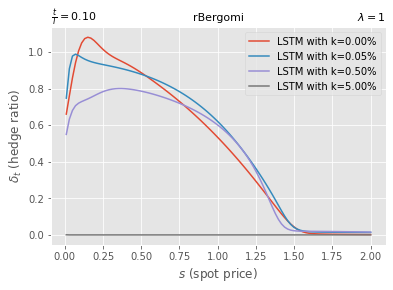

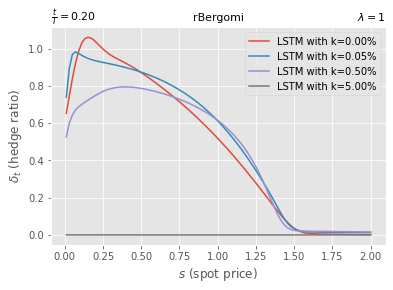

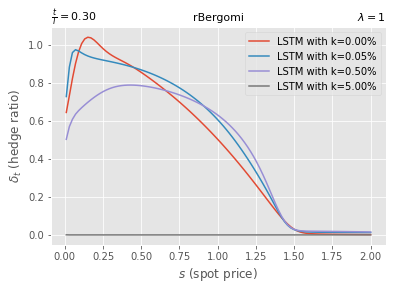

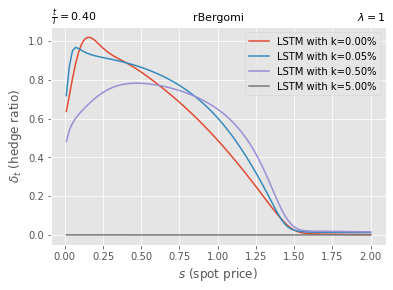

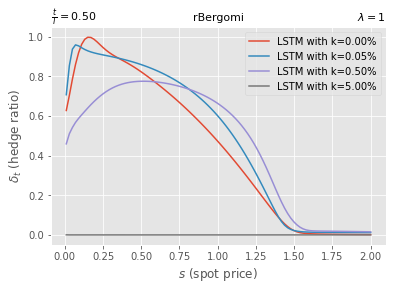

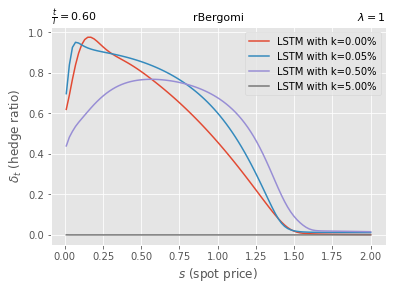

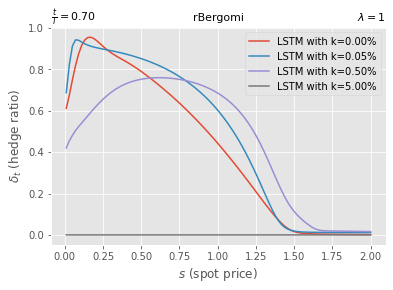

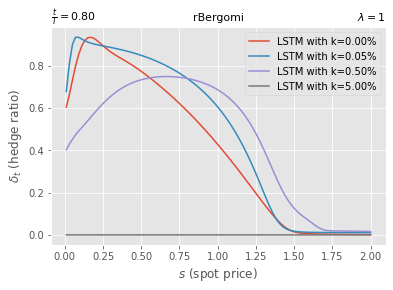

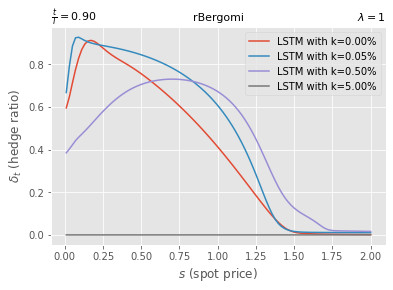

In [ ]:
Lambda=1
I_in_list=0

for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    Spr = np.linspace(0.01, 2, num=100)
    dSpr = Spr[1]-Spr[0]
    Xpr = np.stack([np.reshape(np.repeat(t, 100), (1,100)), np.reshape(Spr, (1,100))], axis=-1)
    for j in range(len(F_BERG[I_in_list])):
        Delta = np.reshape(F_BERG[I_in_list][j].predict(Xpr), (100,))
        k = cost_level[j]*100
        plt.plot(Spr, Delta, label=r"LSTM with k=%1.2f" % k + "%")
    plt.xlabel(r"$s$ (spot price)")
    plt.ylabel(r"$\delta_t$ (hedge ratio)")
    plt.title(r'$\frac{t}{T}=$%1.2f' % t, loc='left', fontsize=11)
    plt.title("rBergomi", loc='center', fontsize=11)
    plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
    plt.legend()
    plt.show()

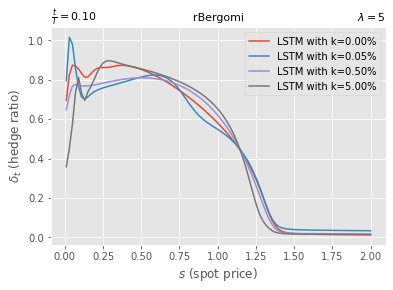

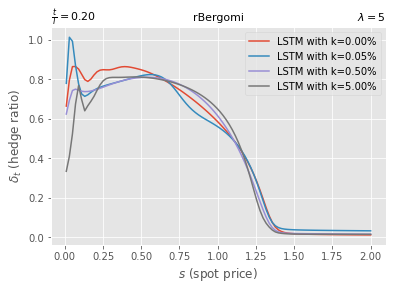

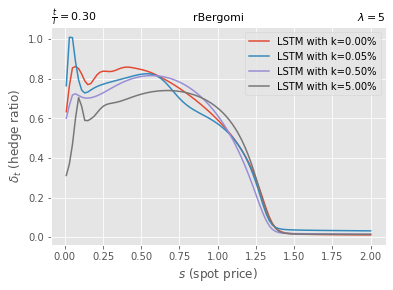

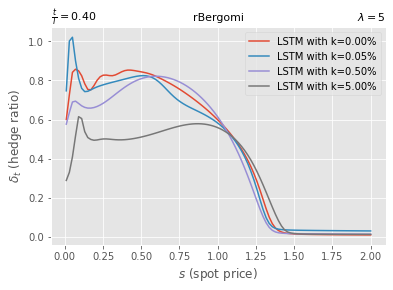

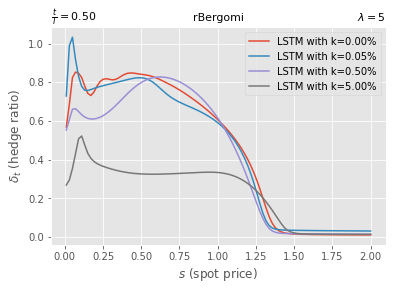

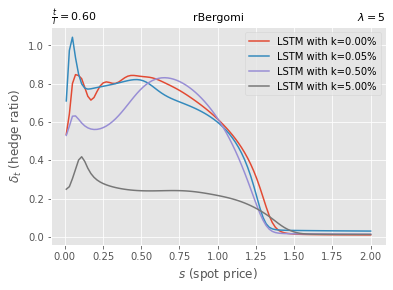

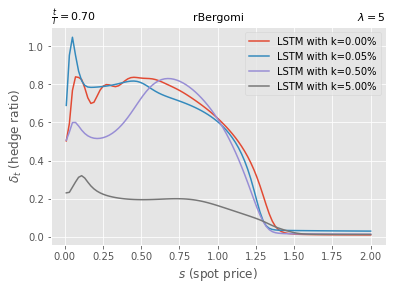

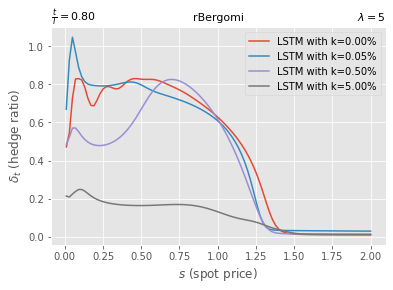

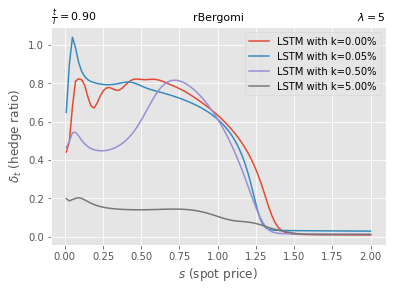

In [ ]:
Lambda=5
I_in_list=1

for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    Spr = np.linspace(0.01, 2, num=100)
    dSpr = Spr[1]-Spr[0]
    Xpr = np.stack([np.reshape(np.repeat(t, 100), (1,100)), np.reshape(Spr, (1,100))], axis=-1)
    for j in range(len(F_BERG[I_in_list])):
        Delta = np.reshape(F_BERG[I_in_list][j].predict(Xpr), (100,))
        k = cost_level[j]*100
        plt.plot(Spr, Delta, label=r"LSTM with k=%1.2f" % k + "%")
    plt.xlabel(r"$s$ (spot price)")
    plt.ylabel(r"$\delta_t$ (hedge ratio)")
    plt.title(r'$\frac{t}{T}=$%1.2f' % t, loc='left', fontsize=11)
    plt.title("rBergomi", loc='center', fontsize=11)
    plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
    plt.legend()
    plt.show()

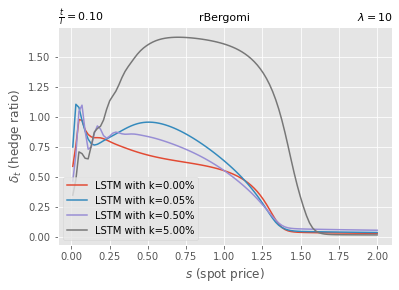

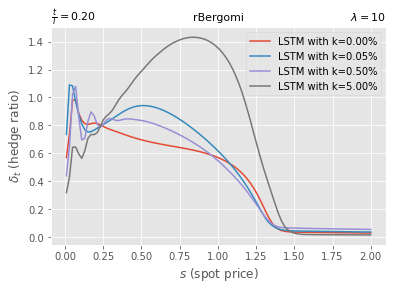

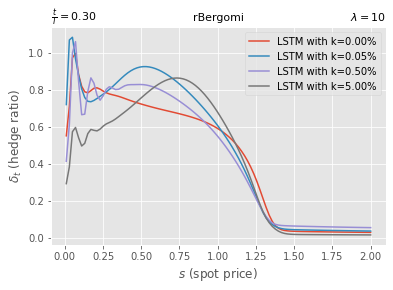

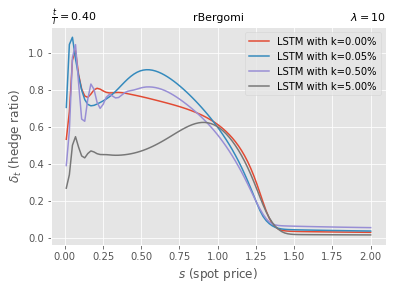

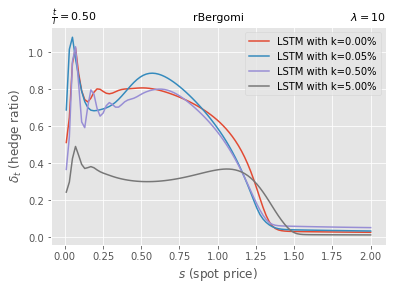

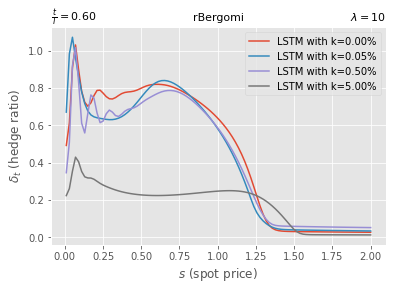

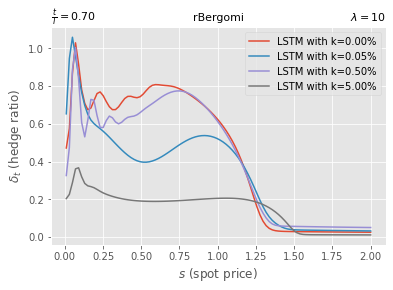

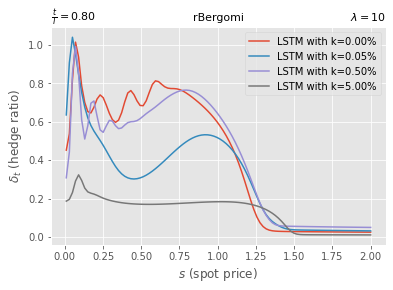

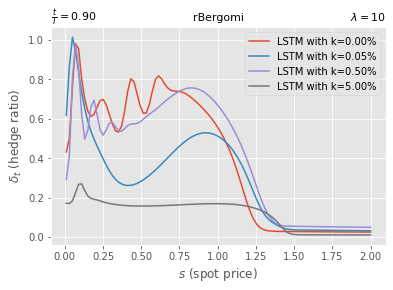

In [ ]:
Lambda=10
I_in_list=2

for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    Spr = np.linspace(0.01, 2, num=100)
    dSpr = Spr[1]-Spr[0]
    Xpr = np.stack([np.reshape(np.repeat(t, 100), (1,100)), np.reshape(Spr, (1,100))], axis=-1)
    for j in range(len(F_BERG[I_in_list])):
        Delta = np.reshape(F_BERG[I_in_list][j].predict(Xpr), (100,))
        k = cost_level[j]*100
        plt.plot(Spr, Delta, label=r"LSTM with k=%1.2f" % k + "%")
    plt.xlabel(r"$s$ (spot price)")
    plt.ylabel(r"$\delta_t$ (hedge ratio)")
    plt.title(r'$\frac{t}{T}=$%1.2f' % t, loc='left', fontsize=11)
    plt.title("rBergomi", loc='center', fontsize=11)
    plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
    plt.legend()
    plt.show()

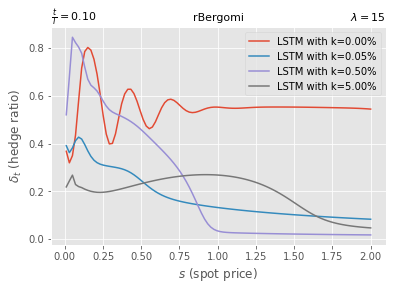

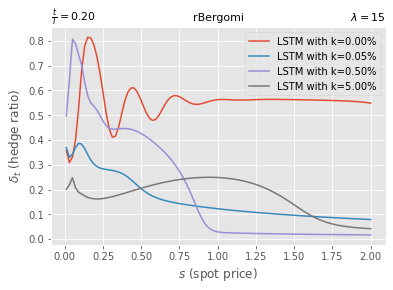

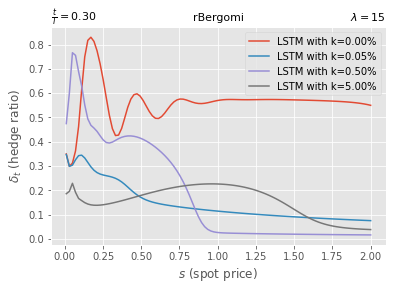

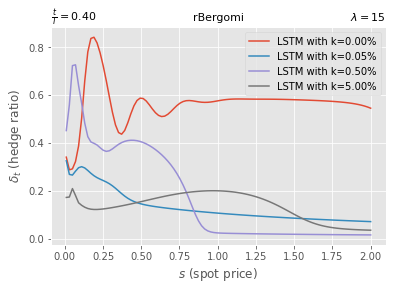

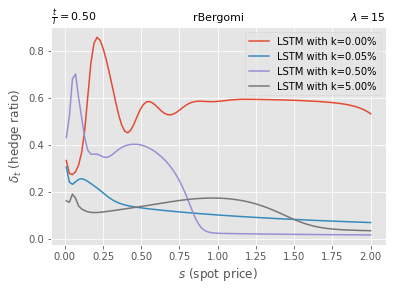

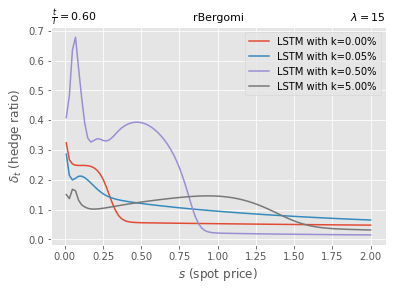

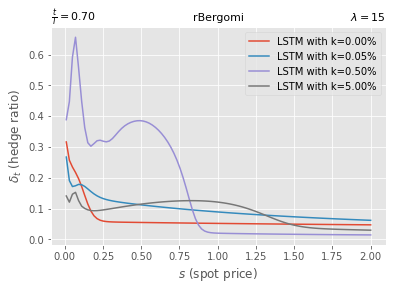

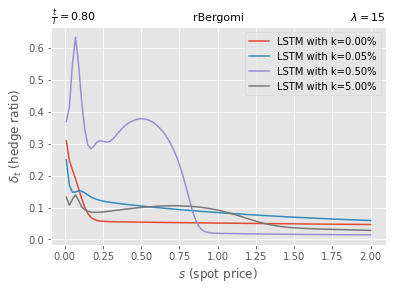

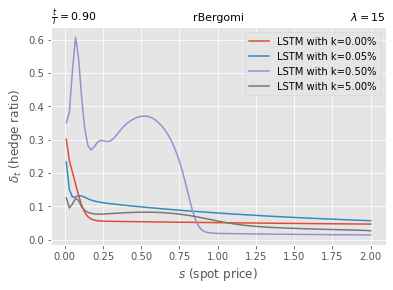

In [ ]:
Lambda=15
I_in_list=3

for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    Spr = np.linspace(0.01, 2, num=100)
    dSpr = Spr[1]-Spr[0]
    Xpr = np.stack([np.reshape(np.repeat(t, 100), (1,100)), np.reshape(Spr, (1,100))], axis=-1)
    for j in range(len(F_BERG[I_in_list])):
        Delta = np.reshape(F_BERG[I_in_list][j].predict(Xpr), (100,))
        k = cost_level[j]*100
        plt.plot(Spr, Delta, label=r"LSTM with k=%1.2f" % k + "%")
    plt.xlabel(r"$s$ (spot price)")
    plt.ylabel(r"$\delta_t$ (hedge ratio)")
    plt.title(r'$\frac{t}{T}=$%1.2f' % t, loc='left', fontsize=11)
    plt.title("rBergomi", loc='center', fontsize=11)
    plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
    plt.legend()
    plt.show()

## Stock Path simulation

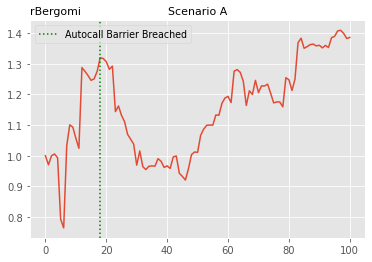

Text(0.0, 1.0, 'rBergomi')

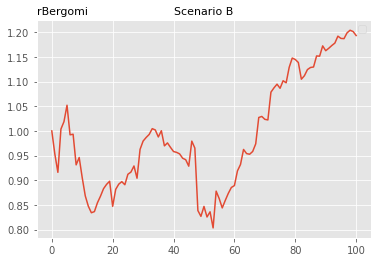

In [ ]:
range_stock_BERG = [25,1]

i  = range_stock_BERG[0]
plt.plot(S_BERG[i])
#plt.axhline(y = B_AC, color = 'green', linestyle='dotted')
plt.axvline(x = 18, color = 'green', label = 'Autocall Barrier Breached', linestyle='dotted')
plt.legend(loc=2,fontsize=9.5)
plt.title(r'Scenario A', loc='center', fontsize=11)
plt.title('rBergomi', loc='left', fontsize=11)
plt.show()

i  = range_stock_BERG[1]
plt.plot(S_BERG[i])
plt.legend()
plt.title(r'Scenario B', loc='center', fontsize=11)
plt.title('rBergomi', loc='left', fontsize=11)

## Delta Hedge Ratio for varying t

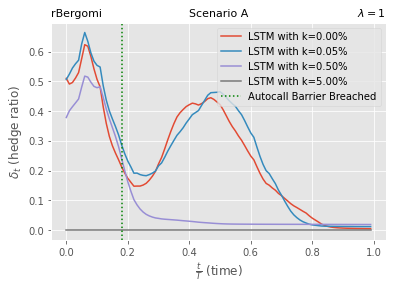

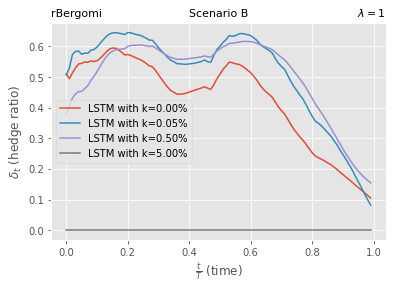

In [ ]:
Lambda=1
I_in_list=0

i  = range_stock_BERG[0]
for j in range(len(F_BERG)):
    Delta_learn = np.reshape(F_BERG[I_in_list][j].predict(X_BERG[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_BERG[i,:,0], Delta_learn, label=r"LSTM with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\delta_t$ (hedge ratio)")
plt.title(r'rBergomi', loc='left', fontsize=11)
plt.title(r'Scenario A', loc='center', fontsize=11)
plt.axvline(x = 0.18, color = 'green', label = 'Autocall Barrier Breached', linestyle='dotted')
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.legend(loc=1)
plt.show()

i  = range_stock_BERG[1]
for j in range(len(F_BERG)):
    Delta_learn = np.reshape(F_BERG[I_in_list][j].predict(X_BERG[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_BERG[i,:,0], Delta_learn, label=r"LSTM with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\delta_t$ (hedge ratio)")
plt.title(r'rBergomi', loc='left', fontsize=11)
plt.title(r'Scenario B', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.legend()
plt.show()

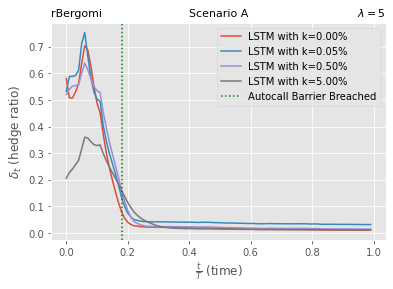

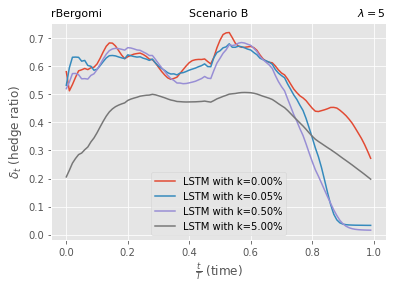

In [ ]:
Lambda=5
I_in_list=1

i  = range_stock_BERG[0]
for j in range(len(F_BERG)):
    Delta_learn = np.reshape(F_BERG[I_in_list][j].predict(X_BERG[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_BERG[i,:,0], Delta_learn, label=r"LSTM with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\delta_t$ (hedge ratio)")
plt.title(r'rBergomi', loc='left', fontsize=11)
plt.title(r'Scenario A', loc='center', fontsize=11)
plt.axvline(x = 0.18, color = 'green', label = 'Autocall Barrier Breached', linestyle='dotted')
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.legend(loc=1)
plt.show()

i  = range_stock_BERG[1]
for j in range(len(F_BERG)):
    Delta_learn = np.reshape(F_BERG[I_in_list][j].predict(X_BERG[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_BERG[i,:,0], Delta_learn, label=r"LSTM with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\delta_t$ (hedge ratio)")
plt.title(r'rBergomi', loc='left', fontsize=11)
plt.title(r'Scenario B', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.legend()
plt.show()

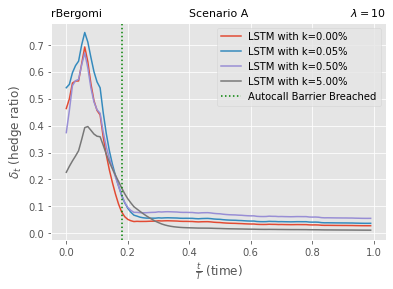

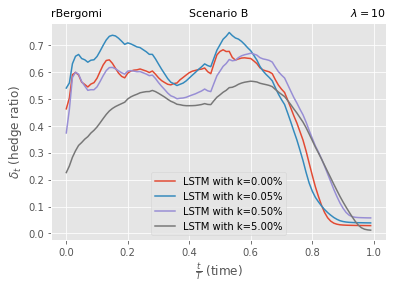

In [ ]:
Lambda=10
I_in_list=2

i  = range_stock_BERG[0]
for j in range(len(F_BERG)):
    Delta_learn = np.reshape(F_BERG[I_in_list][j].predict(X_BERG[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_BERG[i,:,0], Delta_learn, label=r"LSTM with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\delta_t$ (hedge ratio)")
plt.title(r'rBergomi', loc='left', fontsize=11)
plt.title(r'Scenario A', loc='center', fontsize=11)
plt.axvline(x = 0.18, color = 'green', label = 'Autocall Barrier Breached', linestyle='dotted')
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.legend(loc=1)
plt.show()

i  = range_stock_BERG[1]
for j in range(len(F_BERG)):
    Delta_learn = np.reshape(F_BERG[I_in_list][j].predict(X_BERG[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_BERG[i,:,0], Delta_learn, label=r"LSTM with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\delta_t$ (hedge ratio)")
plt.title(r'rBergomi', loc='left', fontsize=11)
plt.title(r'Scenario B', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.legend()
plt.show()

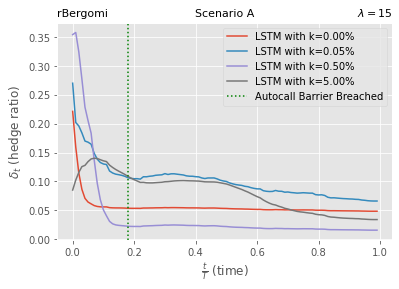

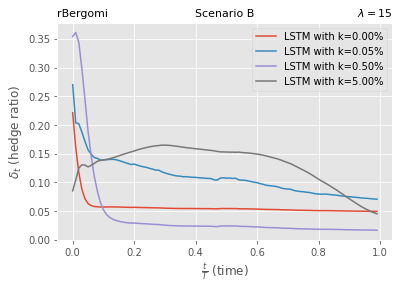

In [ ]:
Lambda=15
I_in_list=3

i  = range_stock_BERG[0]
for j in range(len(F_BERG)):
    Delta_learn = np.reshape(F_BERG[I_in_list][j].predict(X_BERG[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_BERG[i,:,0], Delta_learn, label=r"LSTM with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\delta_t$ (hedge ratio)")
plt.title(r'rBergomi', loc='left', fontsize=11)
plt.title(r'Scenario A', loc='center', fontsize=11)
plt.axvline(x = 0.18, color = 'green', label = 'Autocall Barrier Breached', linestyle='dotted')
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.legend(loc=1)
plt.show()

i  = range_stock_BERG[1]
for j in range(len(F_BERG)):
    Delta_learn = np.reshape(F_BERG[I_in_list][j].predict(X_BERG[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_BERG[i,:,0], Delta_learn, label=r"LSTM with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\delta_t$ (hedge ratio)")
plt.title(r'rBergomi', loc='left', fontsize=11)
plt.title(r'Scenario B', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.legend()
plt.show()